<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/Faza/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I/ Preset**

In [1]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats as st
from scipy.stats import norm, gamma, beta, shapiro, kstest, genextreme, genpareto, probplot, kendalltau, rankdata, multivariate_normal, multivariate_t
import statsmodels.api as sm
from statsmodels.stats.diagnostic import anderson_statistic
from scipy.stats import beta as beta_dist
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import root_scalar, brentq
from scipy.special import gammaln
from scipy.stats import t as student_t

In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_prec = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file_prec)

Mounted at /content/drive


# **II/ Visualisation des données:**


## Visualisation des données de precipitations et définition de X:

In [4]:
ds.sizes

Frozen({'Latitude': 12, 'Longitude': 14, 'time': 30449})

In [5]:
print(ds['time'])

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


In [6]:
ds.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [7]:
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


Le dataset complet (ds) contient les niveaux de précipitation en (kg/m3/s) sur toute la Bretagne par jour de 1940 à 2023.
Il y a en tout 30 449 jours.

**On trace ensuite une carte du premier jour:** 01/01/1940

In [8]:
da = ds['pr'].isel(time=0)   # sélection du premier pas de temps (un jour = une carte)
df = da.to_dataframe().reset_index() # pandas dataframe du premier jour sur toutes les long. lat. de la bretagne

In [9]:
print(da)

<xarray.DataArray 'pr' (Latitude: 12, Longitude: 14)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
    time       datetime64[ns] 8B 1940-01-01
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...


In [10]:
print(df.head())

   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-01 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-01 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-01 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-01 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-01 -3.75  49.0     0.0 NaN


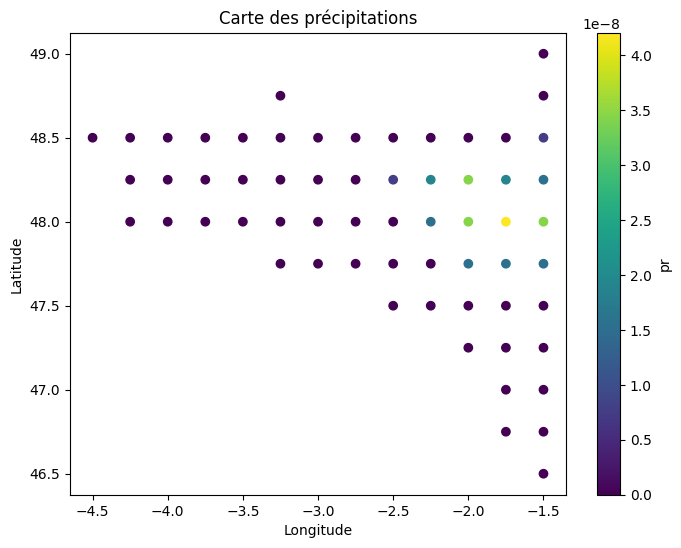

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()

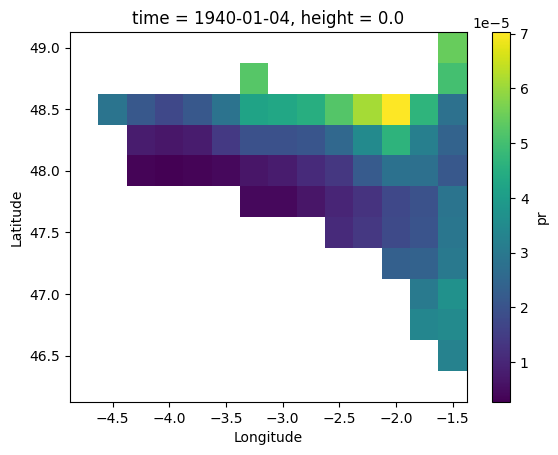

In [12]:
ds.pr[:,:,3].plot() #  On peut aussi tracer comme ça trace ici c'est le jour 4 (04/01/1940)

**Maintenant on sélectionne les mois qui nous intéressent.** Ici Décembre, janvier, février. On appelle ce dataset ds_djf.

In [13]:
ds_djf = ds.sel(time=ds['time'].dt.month.isin([1, 2, 12]))  # sélection des mois DJF
print(ds_djf)
ds_djf.sizes # dimensions du dataset

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

Ce dataset contient maintenant **7550 jours**.
On fait ensuite la **somme par jour des précipitations** sur toute la Bretagne, on appelle cette variable **X**.

In [14]:
# Somme quotidienne des précipitations sur toute la zone en mois DJF
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])  # somme spatiale
print(somme_quotidienne_pr_djf)

X = somme_quotidienne_pr_djf
print(len(X))  # nombre de jours

<xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539758e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685731e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


In [15]:
type(X)

xarray.core.dataarray.DataArray

On **convertit** X de kg/m2/s en mm-1 et on met à jour X.

1 kg/m² = 1 mm d’eau.
Il faut donc multiplier par le nombre de secondes dans une journée.

In [16]:
print("X en kg/m2/s", X)
#conversion de kg/m²/s en mm-1
seconds_per_day = 24 * 60 * 60  # 86400

X_mm_per_day = X * seconds_per_day # x(1000/1000)

# Mettre à jour le DataArray avec une nouvelle unité
X = X_mm_per_day.rename("pr_mm_per_day")
X.attrs['units'] = 'mm/day'
X.attrs['description'] = 'Précipitation journalière convertie de kg/m²/s → mm/j'

print("X en mm-1", X)

X en kg/m2/s <xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539758e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685731e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
X en mm-1 <xarray.DataArray 'pr_mm_per_day' (time: 7550)> Size: 30kB
array([2.3794351e-02, 0.0000000e+00, 3.3809717e+02, ..., 1.1899608e+00,
       2.1328471e+00, 1.8734839e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j


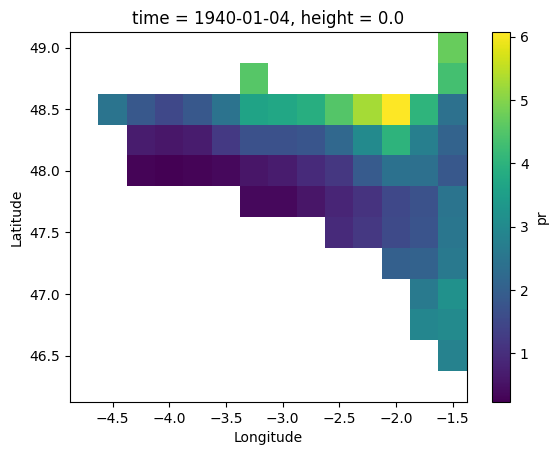

In [17]:
ds_djf['pr'] = ds['pr'] * 86400  # on convertit aussi le dataset en mm-1
ds_djf.pr[:,:,3].plot()

## Visualisation des données de vents et définition de Y:

In [18]:
file_wind = '/content/drive/MyDrive/data/ERA5_wind_daily_1940_2023_FR_brittany.nc'
ds2 = xr.open_dataset(file_wind)

In [19]:
ds2.head()

<xarray.Dataset> Size: 708B
Dimensions:    (Latitude: 5, Longitude: 5, time: 5)
Coordinates:
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 500B ...

In [20]:
ds2.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

Le dataset complet (ds2) contient les maximums de vent par jour (m/s) sur toute la Bretagne de 1940 à 2023.
Il y a en tout 30 449 jours.

On ne garde ensuite que décembre, janvier, février (7550jours).

In [21]:
ds2_djf = ds2.sel(time=ds2['time'].dt.month.isin([1, 2, 12]))  # sélection des mois DJF
print(ds2_djf)
ds2_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

On définit la variable Y qui correspond à la moyenne spatiale (sur la Bretagne) des vitesses de vent.

In [22]:
# Moyenne quotidienne du vent de surface sur la zone (DJF)
mean_quotidienne_sfcWind_djf = ds2_djf['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf)

Y = mean_quotidienne_sfcWind_djf
print(len(Y))    # nombre de jours

<xarray.DataArray 'sfcWind' (time: 7550)> Size: 30kB
array([7.83476  , 7.0278034, 6.5031533, ..., 8.036705 , 7.9032116,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


On définit pour la suite un seuil d'événement extrême à 70%.

In [23]:
threshold = 90 #seuil de percentile (attention seuil quantile=0,70)

# **III/ Analyse Univariée**

## **A) Etude des précipitations (X)**

### **1. Distribution normale**

Paramètres normale : 154.75986 232.3497
Log-vraisemblance maximale : -51847.22511276444
AIC = 103698.45022552888


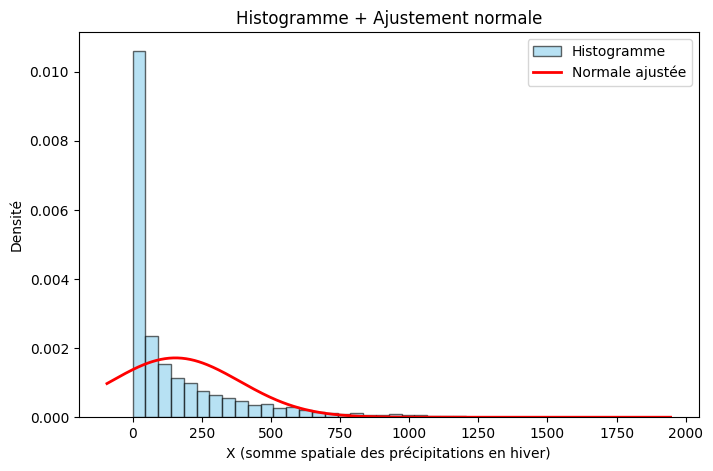

In [24]:
# Ajustement à la loi normale
mu, sigma = norm.fit(X)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(X, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)


On fait des tests statistiques: Shapiro-Wilk (spécialement pour Gaussienne) et Kolmogorov-Smirnov pour valider ou non la distribution.

In [25]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(X)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(X, 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

Test Shapiro-Wilk :
  statistique = 0.693839946624785
  p-value     = 2.6007497848650218e-79 

Test KS (paramètres estimés) :
  statistique = 0.25268329868908956
  p-value     = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7550.
  res = hypotest_fun_out(*samples, **kwds)


**Principe du graphique Quantile-Quantile:**
+ *Axe Horizontal - Quantiles Théoriques:*
 Représente les quantiles théoriques de la distribution normale standard (ou de la distribution normale ajustée aux données).

+ *Axe Vertical - Quantiles réels :* Valeurs Ordonnées
 Représente les valeurs observées (ensemble de données), triées par ordre croissant.

Chaque point bleu représente une observation (ordonnée) et le quantile théorique correspondant (abscisse) ((ie) qu'il devrait avoir si les données suivaient parfaitement la loi normale ajustée).

Si les données suivaient parfaitement la loi normale, tous les points devraient se situer exactement sur la droite y=x, car les quantiles théoriques seraient égaux aux quantiles observés.



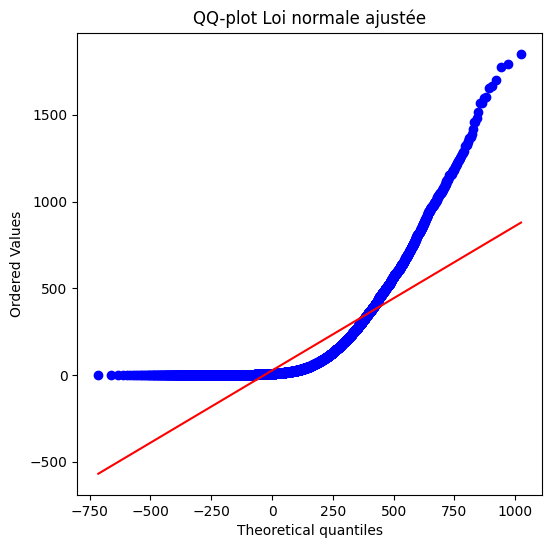

In [26]:
# Diagramme Quantile-Quantile de la normale
plt.figure(figsize=(6,6))
st.probplot(X, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

**Analyse du QQ-Plot de la normale**

Le QQ-plot montre un écart significatif par rapport à l'alignement parfait, indiquant que la distribution des données n'est pas normale :

+ Centre de la Distribution : les points suivent presque la droite, on a donc un comportement quasi-normale au centre.

+ Queue Gauche (Petites Valeurs) : Pas de valeurs négatives dans les précipitations alors que la loi normale centrée en µ (~145mm) en prévoit.

+ Queue Droite (Grandes Valeurs) : Les points bleus s'envolent au-dessus de la ligne rouge. Cela montre qu'il y a des valeurs extrêmes positives. Ces valeurs sont beaucoup plus élevées que ce qu'une distribution normale classique permettrait.

**Conclusion :** La distribution est fortement asymétrique et possède des queues plus épaisses que la distribution normale, ce qui invalide l'hypothèse de normalité pour cet ensemble de données.

### **2. Distribution Gamma**

Paramètres gamma : 0.3968705718016051 397.2107
Log-vraisemblance maximale : -41710.23529423932
AIC = 83424.47058847864


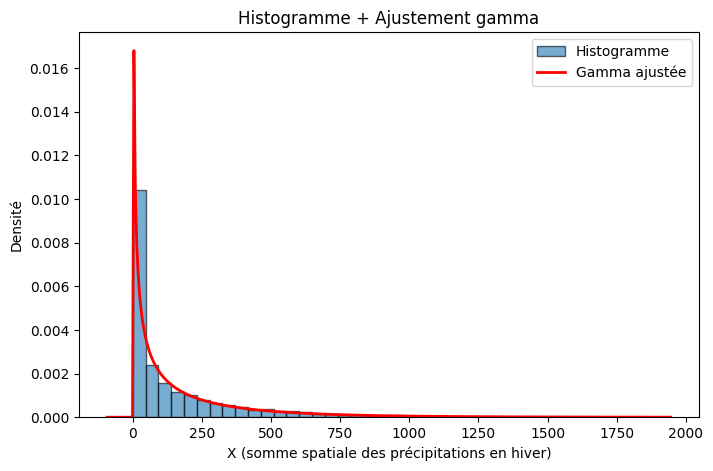

In [27]:
# Garder uniquement les valeurs strictement positives
X_pos = X[X > 0]

# Ajustement à la loi Gamma
alpha, loc, beta = gamma.fit(X_pos, floc=0)        # estimation des paramètres
print("Paramètres gamma :", alpha, beta)

# Histogramme + densité gamma ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X_pos, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")
# Log-vraisemblance
logL_gamma = np.sum(gamma.logpdf(X_pos, alpha, loc=0, scale=beta))
print("Log-vraisemblance maximale :", logL_gamma)

# AIC (k = 2 paramètres : alpha, beta)
AIC_gamma = 2*2 - 2*logL_gamma
print("AIC =", AIC_gamma)

# Courbe théorique gamma ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=beta),
         'r-', lw=2, label="Gamma ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement gamma")
plt.legend()
plt.show()


Statistique KS : 0.025767395597161236
p-value : 0.00010435464383927367


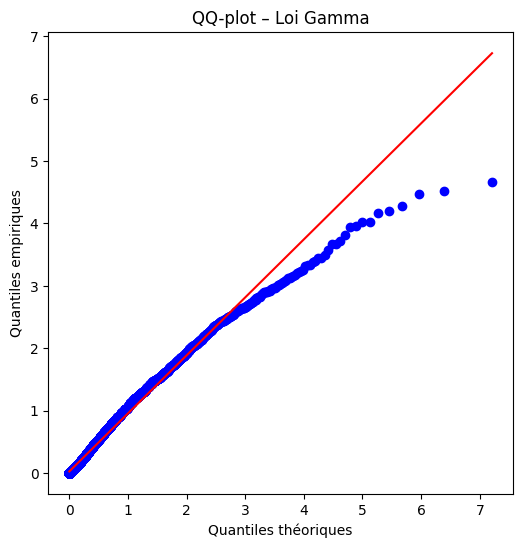

In [28]:
# Test de Kolmogorov–Smirnov pour la loi Gamma ajustée
D, p_value = kstest(X_pos, 'gamma', args=(alpha, 0, beta))

print("Statistique KS :", D)
print("p-value :", p_value)

# Données standardisées (enlever scale)
X_std = X_pos / beta

# QQ-plot Gamma (scale = 1)
plt.figure(figsize=(6,6))
probplot(X_std, dist=gamma, sparams=(alpha,), plot=plt)
plt.title("QQ-plot – Loi Gamma")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles empiriques")
plt.show()


Le QQ-plot montre un bon alignement des quantiles centraux, indiquant que la loi Gamma décrit correctement la partie principale des données.
En revanche, les écarts marqués dans la queue droite révèlent une sous-estimation des événements extrêmes, fréquente pour les précipitations intenses.

*Optionnel: On peut utiliser le bootstrap pour estimer les paramètres*

**Principe:** On veut estimer α (shape) et β (scale) de la loi Gamma pour les précipitations positives X_pos.
On fait un bootstrap : répéter 1000 fois
- tirer un échantillon aléatoire avec remise depuis X_pos
- ajuster une Gamma sur cet échantillon (gamma.fit)
stocker les paramètres estimés α et β

À la fin, on obtient 1000 valeurs de α et β → permet de mesurer l’incertitude sur ces paramètres.

In [29]:
# Bootstrap pour la loi Gamma: ré-échantillonner X_pos et ré-estimer les paramètres Gamma
# Paramètres
n_boot = 1000
alpha_boot = []
beta_boot = []

# Bootstrap
for _ in range(n_boot):
    Xb = np.random.choice(X_pos, size=len(X_pos), replace=True)  # ré-échantillonnage
    a, loc, b = gamma.fit(Xb, floc=0)                             # ajustement gamma
    alpha_boot.append(a)
    beta_boot.append(b)

alpha_boot = np.array(alpha_boot)
beta_boot = np.array(beta_boot)

In [30]:
# Intervalles de confiance (95 %)
alpha_ci = np.percentile(alpha_boot, [2.5, 97.5])
beta_ci  = np.percentile(beta_boot,  [2.5, 97.5])

print("IC 95% alpha :", alpha_ci)
print("IC 95% beta  :", beta_ci)

IC 95% alpha : [0.38769359 0.40689085]
IC 95% beta  : [381.81170044 413.14652863]


### **3. Distribution Beta**

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Paramètres beta : 0.5156684854540652 108.17750526493276 -0.0012271106243133547 10870.305832815706
Log-vraisemblance maximale : -45330.30384309996
AIC = 90668.60768619992


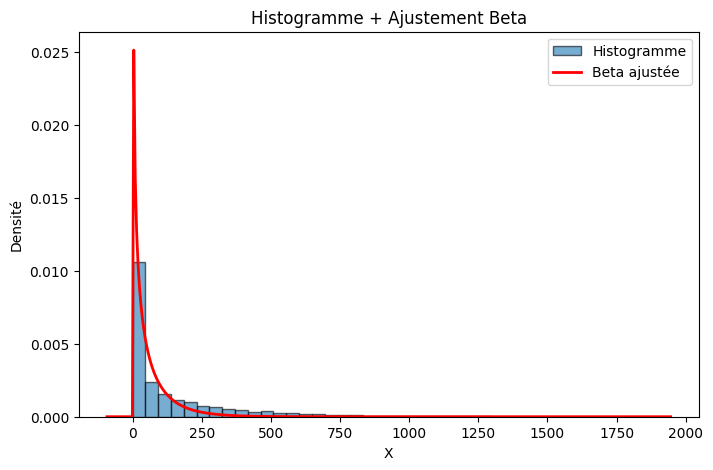

In [31]:
# Ajustement à la loi Beta (avec loc et scale libres)
a, b, loc, scale = beta_dist.fit(X)
print("Paramètres beta :", a, b, loc, scale)

# Histogramme + densité beta ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance
logL_beta = np.sum(beta_dist.logpdf(X, a, b, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL_beta)

# AIC (4 paramètres : a, b, loc, scale)
AIC_beta = 2*4 - 2*logL_beta
print("AIC =", AIC_beta)

# Courbe théorique beta ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc, scale=scale),
         'r-', lw=2, label="Beta ajustée")

plt.xlabel("X")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Beta")
plt.legend()
plt.show()


Statistique KS : 0.2300712918483221
p-value : 0.0


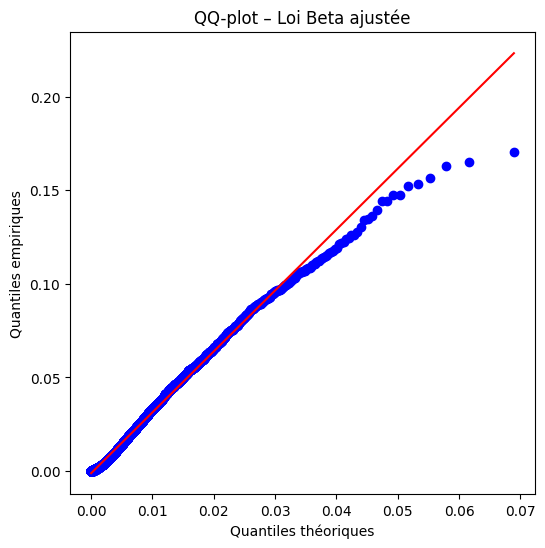

In [32]:
# Test KS pour la loi Beta ajustée
D, p_value = kstest(X, 'beta', args=(a, b, loc, scale))
print("Statistique KS :", D)
print("p-value :", p_value)

# Recentrage / rescaling sur [0,1]
X_std = (X - loc) / scale

# QQ-plot pour la loi Beta
plt.figure(figsize=(6,6))
probplot(X_std, dist=beta_dist, sparams=(a, b), plot=plt)
plt.title("QQ-plot – Loi Beta ajustée")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles empiriques")
plt.show()

Le QQ-plot montre un bon accord pour les quantiles centraux, ce qui indique que la loi Beta ajustée reproduit correctement la masse principale des données.
Les écarts visibles dans la queue droite traduisent toutefois une mauvaise représentation des valeurs extrêmes, confirmant les limites de ce modèle pour les fortes précipitations.

**On s'intéressera donc, ensuite, aux queues de distribution**

## **B) Etude des queues de distribution pour les précipitations**

### 1.Définition des variables:

On définit quatre variables :

1) **WinterPI :** la somme des précipitations sur tout l’hiver DJF (Décembre-Janvier-Février) en mm.

2) **Somme_mois :** la somme des précipitations pour chaque mois de l’hiver DJF en mm.

3) **pr_max_an :** la précipitation maximale observée sur un jour de chaque hiver (DJF), en mm.

4) **pr_max_mois :** la valeur maximale de précipitation enregistrée sur un jour pour chaque mois, exprimée en mm.

Toutes les variables sont calculées sur toutes la Bretagne (somme spatiale déjà faite dans X)  

In [33]:
# max par mois, on revient au dataset pour récuperer les mois et trouver les max
# Créer un DataArray 'year_month' correspondant à chaque date
year_month = xr.DataArray(
    ds_djf['time'].dt.year * 100 + ds_djf['time'].dt.month,  # format YYYYMM
    coords={'time': ds_djf['time']},
    dims='time'
)

# Maximum journalier par mois (somme spatiale)
pr_journalier = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])
pr_max_mois = pr_journalier.groupby(year_month).max() # c'est X en fait

print(pr_max_mois)
print("Nombre de mois :", len(pr_max_mois))

<xarray.DataArray 'pr' (group: 251)> Size: 2kB
array([ 850.2220459 ,  464.00048828,  769.93200684, 1794.25537109,
        762.6328125 ,  342.68151855,  726.2164917 ,  280.86608887,
        811.66278076, 1852.70739746,  680.73205566,  852.71228027,
        595.66345215,  221.47875977, 1219.31616211,  554.06793213,
        679.87469482,  637.32244873,  766.44262695,  605.54882812,
        913.55566406,  479.22973633,  570.29772949, 1202.86474609,
       1006.94647217,  264.10003662, 1100.08166504,  943.22338867,
        407.48904419,  551.35992432,  535.56384277, 1184.3659668 ,
        873.37780762,  719.40411377, 1286.73046875,  740.32434082,
        544.80175781,  301.4230957 , 1117.35253906,  524.01147461,
        519.02972412,  298.7855835 ,  802.26483154,  721.10748291,
        832.33569336, 1196.89672852,  900.93688965,  650.94091797,
        959.5255127 ,  149.84983826,  799.70690918,  254.70201111,
        993.44018555,  720.20758057,  839.918396  ,  819.25268555,
        567.833

In [34]:
# Somme journalière spatiale
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude']) # c'est X en fait

# Somme totale par hiver
# on définit l'hiver en comptant: décembre de l'année i-1 et janvier, février de l'année i
annee_hiver = ds_djf['time.year'].where(ds_djf['time.month'] != 12, ds_djf['time.year'] + 1)
WinterPI = ds_djf['pr'].groupby(annee_hiver).sum(dim=['time', 'Latitude', 'Longitude'])
WinterPI = WinterPI.assign_coords(year=np.unique(annee_hiver.values))

# Somme mensuelle
Somme_mois = (
    ds_djf['pr']
    .sum(dim=['Latitude', 'Longitude'])  # somme spatiale
    .groupby(year_month)
    .sum(dim='time')                     # somme TEMPORELLE
)

# maximum par an
pr_max_an = ds_djf['pr'].sum(dim=['Latitude','Longitude']).groupby('time.year').max()

# Affichage final
print(annee_hiver)
print("WinterPI (somme d'un hiver DJF)", WinterPI)
print("Nombre d'hivers :", len(WinterPI))

print("Somme par mois (DJF)", Somme_mois)
print("Nombre de mois :", len(Somme_mois))

print("Max par mois (précipitation journalière max)",pr_max_an )
print("Nombre d'année :", len(pr_max_an))
pr_max_an.shape


<xarray.DataArray 'year' (time: 7550)> Size: 60kB
array([1940, 1940, 1940, ..., 2023, 2023, 2023])
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B 0.0
WinterPI (somme d'un hiver DJF) <xarray.DataArray 'pr' (year: 84)> Size: 336B
array([ 8377.799 , 15172.459 ,  7901.8545, 16133.89  ,  6146.8125,
       11490.911 , 13386.957 , 11288.445 , 13297.986 , 12569.238 ,
       13358.568 , 17136.406 ,  9778.834 ,  9171.723 ,  8722.051 ,
       15582.819 , 11727.835 , 17879.463 , 15123.016 , 11449.756 ,
       18136.957 , 16163.619 , 14360.942 ,  8398.139 ,  6663.288 ,
       12529.6875, 20239.215 , 14259.468 , 11374.627 , 12065.504 ,
       15991.568 ,  9821.185 , 15085.014 ,  9259.478 , 17334.346 ,
        9132.387 ,  5769.491 , 17019.125 , 19609.29  , 24382.764 ,
       16323.769 ,  9715.227 , 18556.426 , 13831.113 , 15407.055 ,
       14046.289 , 16734.344 ,  9234.358 , 20176.715 ,  7646.9746,
       24017.86  , 12432.268 ,  396

(84,)

In [35]:
print(len(Somme_mois)) #vérification en regardant le nombre de mois pris en compte (normalement: 84*3-1=251)
print(len(Somme_mois))
np.unique(year_month)[:252]
np.unique(year_month)[-252:]

251
251


array([194001, 194002, 194012, 194101, 194102, 194112, 194201, 194202,
       194212, 194301, 194302, 194312, 194401, 194402, 194412, 194501,
       194502, 194512, 194601, 194602, 194612, 194701, 194702, 194712,
       194801, 194802, 194812, 194901, 194902, 194912, 195001, 195002,
       195012, 195101, 195102, 195112, 195201, 195202, 195212, 195301,
       195302, 195312, 195401, 195402, 195412, 195501, 195502, 195512,
       195601, 195602, 195612, 195701, 195702, 195712, 195801, 195802,
       195812, 195901, 195902, 195912, 196001, 196002, 196012, 196101,
       196102, 196112, 196201, 196202, 196212, 196301, 196302, 196312,
       196401, 196402, 196412, 196501, 196502, 196512, 196601, 196602,
       196612, 196701, 196702, 196712, 196801, 196802, 196812, 196901,
       196902, 196912, 197001, 197002, 197012, 197101, 197102, 197112,
       197201, 197202, 197212, 197301, 197302, 197312, 197401, 197402,
       197412, 197501, 197502, 197512, 197601, 197602, 197612, 197701,
      

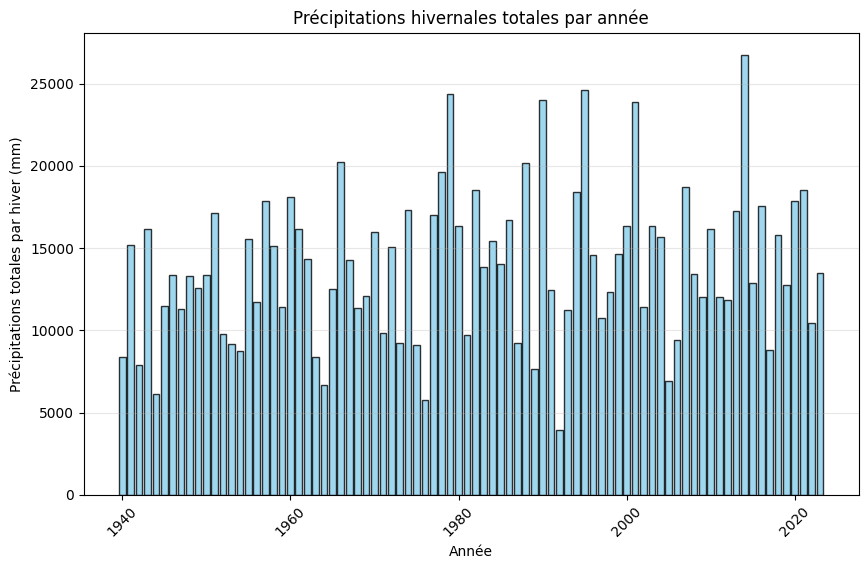

In [36]:
# Histogramme des précipitations par hiver pour chaque année
plt.figure(figsize=(10,6))
plt.bar(WinterPI.year, WinterPI.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Année")
plt.ylabel("Précipitations totales par hiver (mm)")
plt.title("Précipitations hivernales totales par année")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 2.GEV sur les maximums hivernaux de précipitation

On trace d'abord l'histogramme des maximums hivernaux et l'ajustement normal

mu: 1126.0542566208612 sigma: 283.617696970373


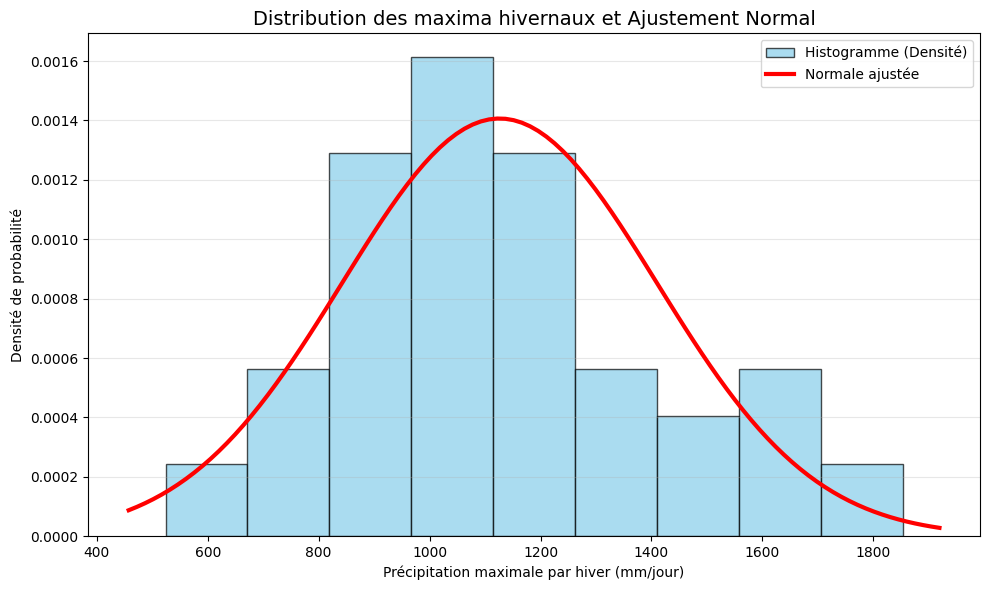

In [37]:
# Tracé de l'histogramme en densité
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (sqrt(N) ici) pour le pas de l'histogramme
bins = int(np.sqrt(len(pr_max_an.values)))

plt.hist(pr_max_an.values, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# Courbe normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)

mu, sigma = norm.fit(pr_max_an.values)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée')
print("mu:", mu, "sigma:", sigma)

# Labels et légende
plt.xlabel("Précipitation maximale par hiver (mm/jour)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des maxima hivernaux et Ajustement Normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

On trace ensuite la GEV sur les max hivernaux (on définit les paramètres c1, loc1, scale1)

Paramètres GEV ajustés :
 c (shape) = 0.107, loc1 = 1006.42, scale1 = 246.88


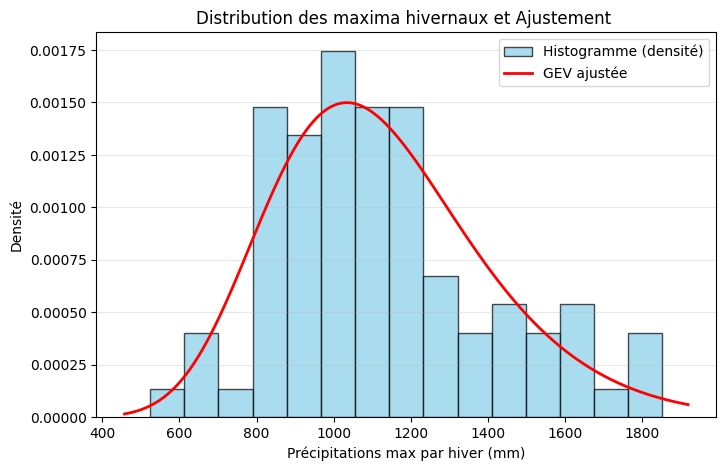

In [38]:
# Ajustement GEV
# genextreme utilise un paramètre c1 (shape), loc1 (location), scale1 (scale)
c1, loc1, scale1 = genextreme.fit(pr_max_an.values)
print(f"Paramètres GEV ajustés :\n c (shape) = {c1:.3f}, loc1 = {loc1:.2f}, scale1 = {scale1:.2f}")

# Histogramme en densité
plt.figure(figsize=(8,5))
plt.hist(pr_max_an.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c1, loc1, scale1), 'r-', lw=2, label='GEV ajustée')

# Labels et légende
plt.xlabel("Précipitations max par hiver (mm)")
plt.ylabel("Densité")
plt.title("Distribution des maxima hivernaux et Ajustement ")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



**Lien avec le cours:**

ξ=c (paramètre de forme ou shape)

μ=loc (paramètre de position ou location)

σ=scale (paramètre d'échelle ou scale)

On calcule l'AIC et la p-value pour cette distribution.

In [39]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c1, loc1, scale1).cdf(x)

# KS-test
ks_stat, ks_p = kstest(WinterPI.values, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genextreme.logpdf(WinterPI.values, c1, loc1, scale1))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)



Test KS (GEV ajustée) :
  Statistique = 1.0
  p-value     = 0.0
Log-vraisemblance maximale : -inf
AIC = inf


**Raisons du Mauvais Ajustement**

On a trop peu de valeurs

### 3.GEV sur les maximums mensuels de précipitation

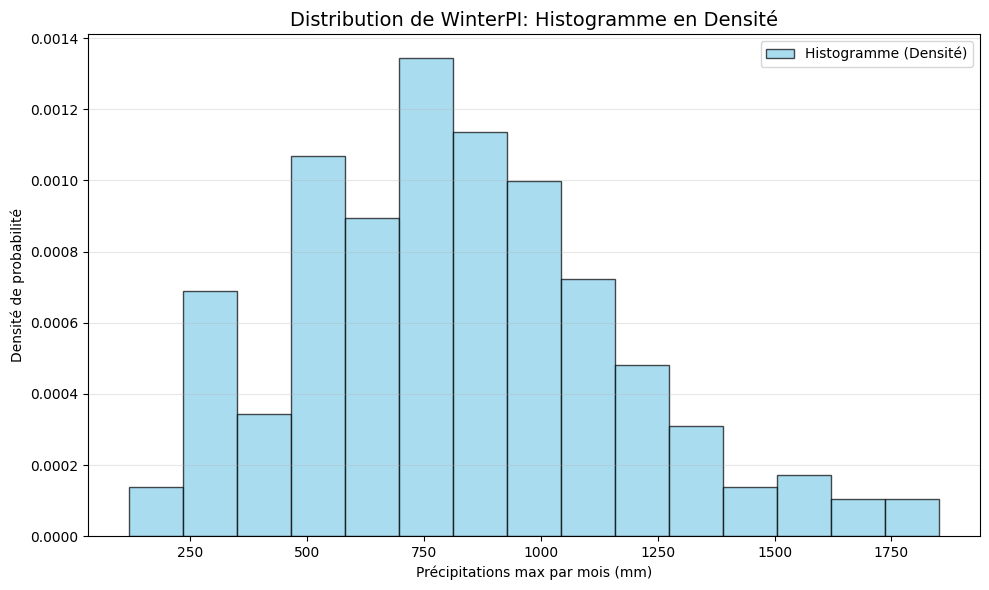

In [40]:
# Tracé de l'histogramme en densité
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(pr_max_mois)))

plt.hist(pr_max_mois, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# Labels et légende
plt.xlabel("Précipitations max par mois (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Paramètres GEV ajustés :
 c (shape) = -5.748, loc2 = 118.06, scale2 = 2.69


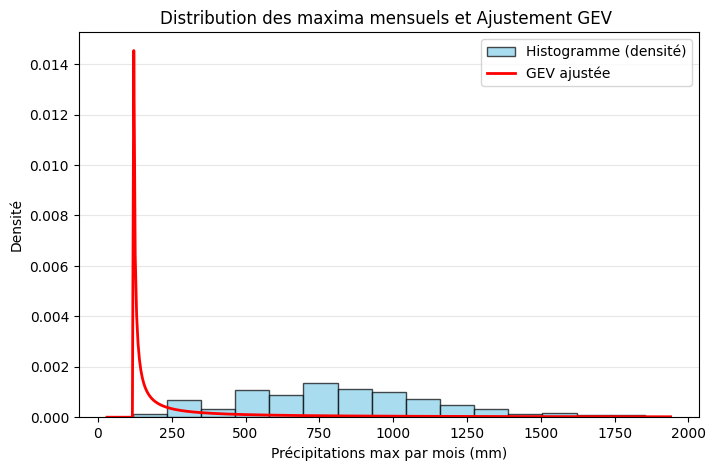

In [41]:
# Ajustement GEV
# genextreme utilise un paramètre c2 (shape), loc2 (location), scale2 (scale)
c2, loc2, scale2 = genextreme.fit(pr_max_mois)
print(f"Paramètres GEV ajustés :\n c (shape) = {c2:.3f}, loc2 = {loc2:.2f}, scale2 = {scale2:.2f}")

# Histogramme en densité
plt.figure(figsize=(8,5))
plt.hist(pr_max_mois.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c2, loc2, scale2), 'r-', lw=2, label='GEV ajustée')

# Labels et légende
plt.xlabel("Précipitations max par mois (mm)")
plt.ylabel("Densité")
plt.title("Distribution des maxima mensuels et Ajustement GEV ")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [42]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c2, loc2, scale2).cdf(x)

# KS-test
ks_stat, ks_p = kstest(pr_max_mois, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.6682615331294652
  p-value     = 5.30159468737167e-111


### 4.GPD sur le cumul hivernal de précipitation

nombre de valeurs prises en compte : 9


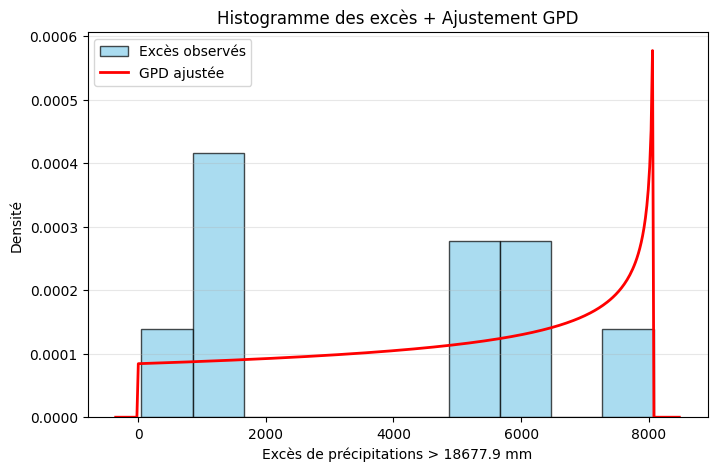

Paramètres GPD : shape(c)=-1.467, loc3=-13.6, scale3=11865.7


In [43]:

# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(WinterPI.values, threshold)  # 70ème percentile
exceedances_W = WinterPI.values[WinterPI.values > seuil] - seuil  # excès au-dessus du seuil
print("nombre de valeurs prises en compte :", len(exceedances_W))
# 2. Ajuster la GPD aux excès
c3, loc3, scale3 = genpareto.fit(exceedances_W)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_W, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c3, loc3, scale3), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c3:.3f}, loc3={loc3:.1f}, scale3={scale3:.1f}")


In [44]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c3, loc3, scale3).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_W, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_W, c3, loc3, scale3))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.3072118010949558
  p-value     = 0.29801287268260923
Log-vraisemblance maximale : -71.07793793446845
AIC = 148.1558758689369


**Remarque**: on a peu de valeurs pourtant on a pris un seuil bas, donc on passe au cumul par mois

### 5.GPD sur le cumul mensuel de précipitation

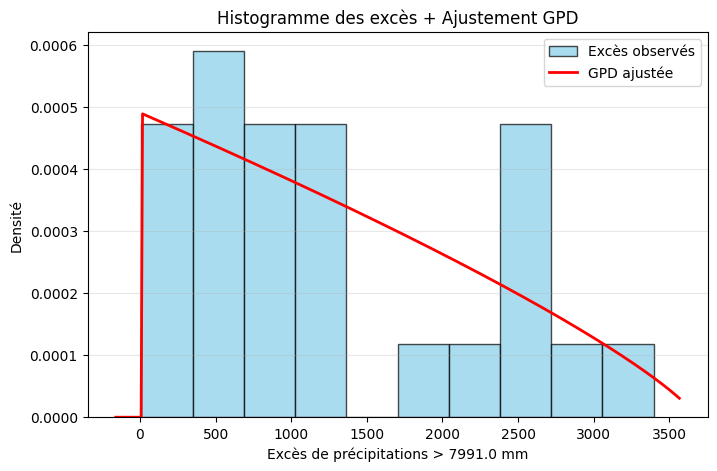

Paramètres GPD : shape(c)=-0.557, loc4=9.2, scale4=2043.6


In [45]:
# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(Somme_mois, threshold)  # 70ème percentile
exceedances_M = Somme_mois[Somme_mois > seuil] - seuil  # excès au-dessus du seuil

# 2. Ajuster la GPD aux excès
c4, loc4, scale4 = genpareto.fit(exceedances_M)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_M, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c4, loc4, scale4), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c4:.3f}, loc4={loc4:.1f}, scale4={scale4:.1f}")

In [46]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c4, loc4, scale4).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_M, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_M, c4, loc4, scale4))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.1604812276682111
  p-value     = 0.4906743567222869
Log-vraisemblance maximale : -201.63857868638584
AIC = 409.2771573727717


Les valeurs sont satisfaisantes

### 6.GPD sur le cumul journalier de précipitation

Ici on traite X.

In [47]:
print("len(X) =", len(X))
print("min(X), max(X) =", np.nanmin(X), np.nanmax(X))

seuil = np.nanpercentile(X, threshold)
print("seuil =", seuil)

print("nb X > seuil =", np.sum(X > seuil))

len(X) = 7550
min(X), max(X) = -0.0012271106 1852.7074
seuil = 469.07782
nb X > seuil = <xarray.DataArray 'pr_mm_per_day' ()> Size: 8B
array(755)
Coordinates:
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j


Avec un seuil à 70%, on conserve 2265 jours.

Nombre d'excès : 755


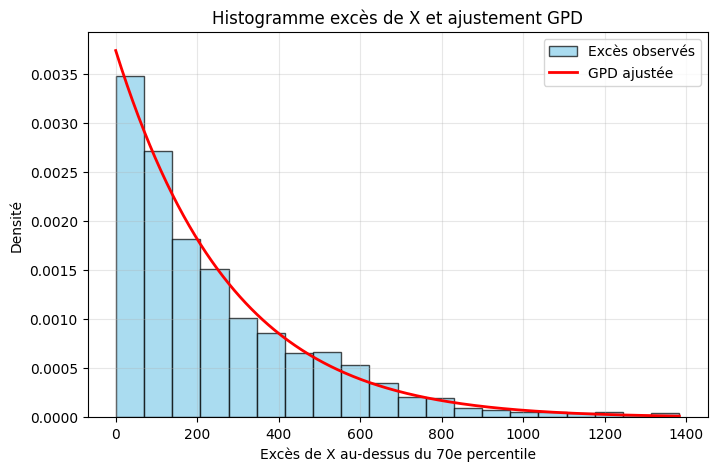

Paramètres GPD : shape=-0.056, scale=267.272


In [48]:
X_np = X.values

# Seuil
seuil = np.percentile(X_np, threshold)

# Excès
exceedances_D = X_np[X_np > seuil] - seuil
print("Nombre d'excès :", len(exceedances_D))

# Ajustement GPD
c4, loc4, scale4 = genpareto.fit(exceedances_D, floc=0)

# Histogramme
plt.figure(figsize=(8,5))
plt.hist(exceedances_D, bins=20, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Excès observés')

# Courbe GPD
xx = np.linspace(0, exceedances_D.max(), 400)
plt.plot(xx, genpareto.pdf(xx, c4, loc=0, scale=scale4),
         'r-', lw=2, label='GPD ajustée')

plt.xlabel("Excès de X au-dessus du 70e percentile")
plt.ylabel("Densité")
plt.title("Histogramme excès de X et ajustement GPD")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Paramètres GPD : shape={c4:.3f}, scale={scale4:.3f}")


In [49]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c4, loc4, scale4).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_D, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_D, c4, loc4, scale4))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.025440384757766832
  p-value     = 0.702914446190555
Log-vraisemblance maximale : -4931.959020160896
AIC = 9869.918040321792


## **C) Etude des vents (Y)**

### **1. Distribution normale**

Paramètres normale : 6.404704 2.435008
Log-vraisemblance maximale : -17432.108996604413
AIC = 34868.217993208826
Test Shapiro-Wilk :
  statistique = 0.9672969459683689
  p-value     = 2.9708778349767306e-38 

Test KS :
  statistique = 0.05665506752885069
  p-value     = 1.6627855320132638e-21


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7550.
  res = hypotest_fun_out(*samples, **kwds)


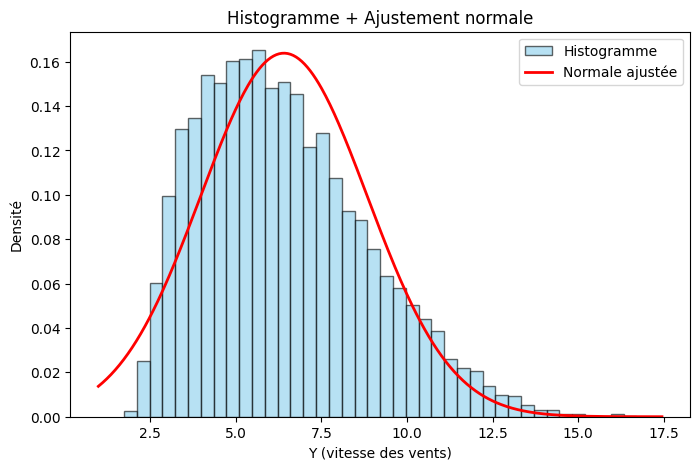

In [50]:
# Pour Y
# Ajustement à la loi normale
mu, sigma = norm.fit(Y)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(Y, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)

# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(Y)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(Y, 'norm', args=(mu, sigma))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


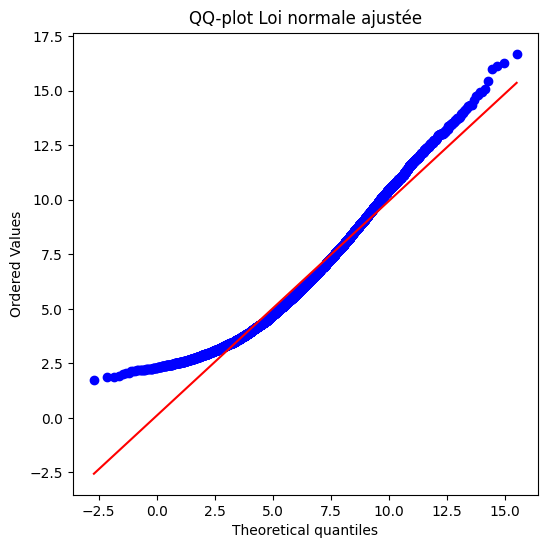

In [51]:
# Diagramme Quantile-Quantile de la noramle
plt.figure(figsize=(6,6))
st.probplot(Y, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

Le QQ-plot montre un écart systématique à la droite, indiquant que la loi normale ne décrit pas correctement la distribution des vitesses de vent.
Les déviations marquées aux extrémités révèlent une asymétrie et des queues mal représentées par le modèle normal.

### **2. Distribution Gamma**

Paramètres gamma : 6.958205547890324 397.2107
Log-vraisemblance maximale : -283367.9744002754
AIC = 566739.9488005508
Test KS :
  statistique = 0.9999999999999448
  p-value     = 0.0


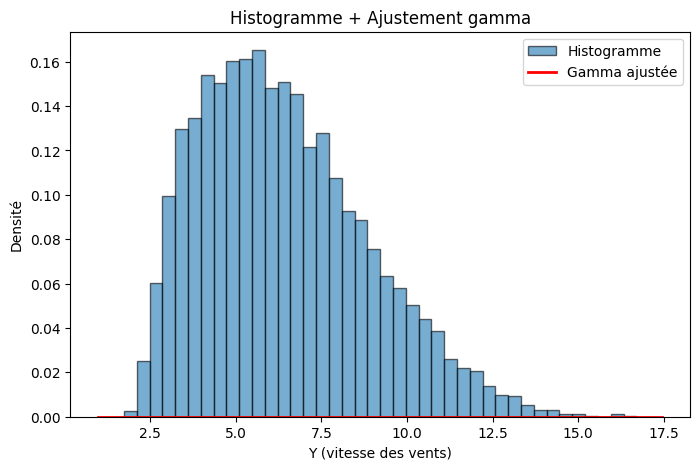

In [52]:
Y_pos = Y[Y > 0]

# Ajustement à la loi Gamma
alpha, loc, scale_gamma = gamma.fit(Y_pos, floc=0)
print("Paramètres gamma :", alpha, beta)

# Histogramme + densité gamma ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y_pos, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance
logL_gamma = np.sum(gamma.logpdf(Y_pos, alpha, loc=0, scale=beta))
print("Log-vraisemblance maximale :", logL_gamma)

# AIC (k = 2 paramètres : alpha, beta)
AIC_gamma = 2*2 - 2*logL_gamma
print("AIC =", AIC_gamma)

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(Y_pos, 'gamma', args=(alpha, 0, beta))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Courbe théorique gamma ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=beta),
         'r-', lw=2, label="Gamma ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement gamma")
plt.legend()
plt.show()

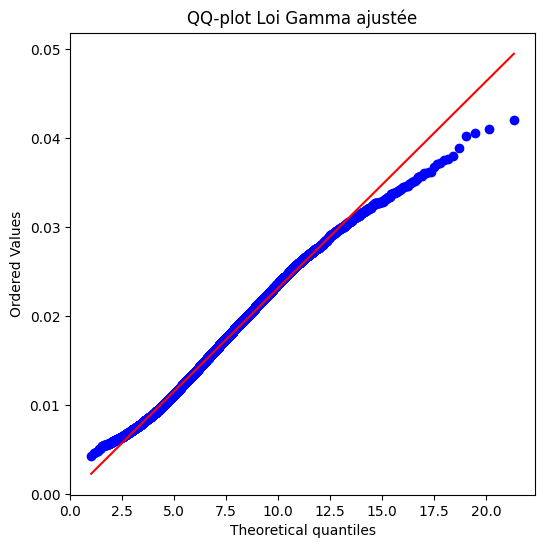

In [53]:
# Diagramme Quantile-Quantile de la loi Gamma
plt.figure(figsize=(6,6))

# Données standardisées (enlever scale)
Y_std = Y_pos / beta

st.probplot(Y_std, dist=gamma, sparams=(alpha,), plot=plt)

plt.title("QQ-plot Loi Gamma ajustée")
plt.show()

Le QQ-plot montre un bon alignement des quantiles centraux, indiquant que la loi Gamma décrit correctement la distribution des vitesses de vent.
Les écarts observés dans la queue droite suggèrent toutefois une légère sous-estimation des valeurs de vent les plus élevées.

### **3. Distribution Beta**

Paramètres beta : 2.5998714817204203 8.020162750398065 1.7112824615289306 19.179872124456743
Log-vraisemblance maximale : -16938.48245874719
AIC = 33884.96491749438
Test KS :
  statistique = 0.012781828090994984
  p-value     = 0.1681412946975085


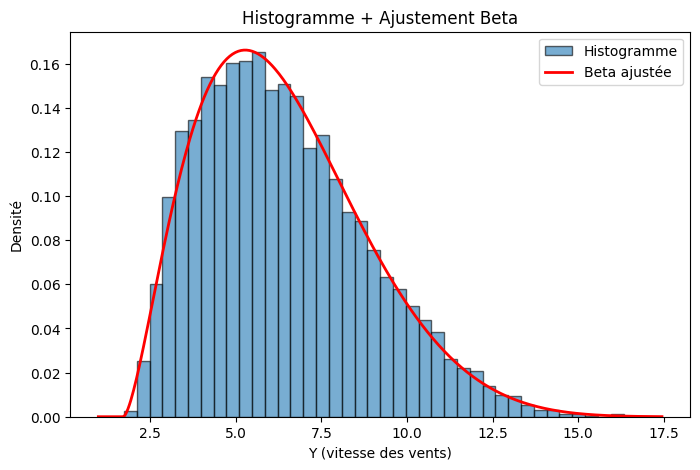

In [54]:
# Ajustement à la loi Beta
a, b, loc, scale = beta_dist.fit(Y)
print("Paramètres beta :", a, b, loc, scale)

# Histogramme + densité beta ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance (UTILISER beta_dist, pas beta)
logL_beta = np.sum(beta_dist.logpdf(Y, a, b, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL_beta)

# AIC : 4 paramètres (a, b, loc, scale)
AIC_beta = 2*4 - 2*logL_beta
print("AIC =", AIC_beta)

# KS (Kolmogorov–Smirnov)
ks_stat, ks_p = kstest(Y, 'beta', args=(a, b, loc, scale))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Courbe théorique beta ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc, scale=scale),
         'r-', lw=2, label="Beta ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Beta")
plt.legend()
plt.show()


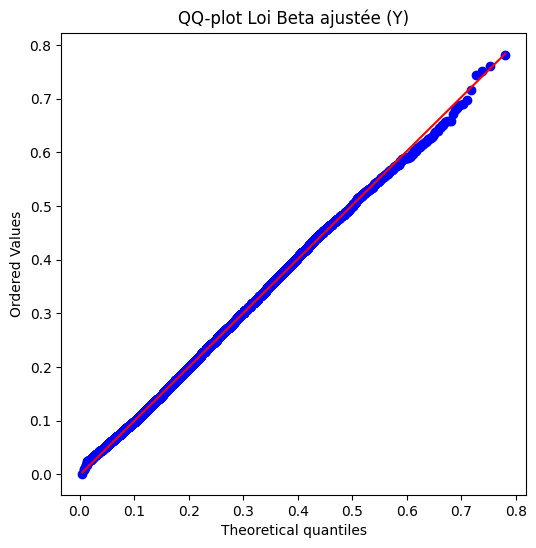

In [55]:
# Recentrer / re-scaler Y pour revenir sur [0,1]
Y_std = (Y - loc) / scale

# QQ-plot Beta avec probplot
plt.figure(figsize=(6,6))
st.probplot(Y_std, dist=beta_dist, sparams=(a, b), plot=plt)
plt.title("QQ-plot Loi Beta ajustée (Y)")
plt.show()

Le QQ-plot montre un très bon alignement sur l’ensemble des quantiles, indiquant que la loi Beta ajustée décrit bien la distribution des vitesses de vent.
Les légers écarts en queue droite restent faibles et suggèrent un ajustement globalement satisfaisant, meilleur que celui de la loi normale.

### **4. GPD pour Y: moyenne de vent journalière**

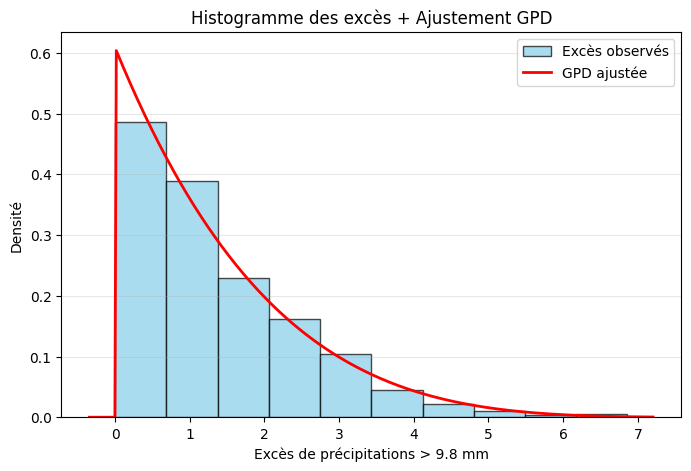

Paramètres GPD : shape(c)=-0.187, loc5=1.7, scale5=1.6


In [56]:
# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(Y, threshold)  # 70ème percentile
exceedances_YD = Y[Y > seuil] - seuil  # excès au-dessus du seuil

# 2. Ajuster la GPD aux excès
c5, loc5, scale5 = genpareto.fit(exceedances_YD)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_YD, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c5, loc5, scale5), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c5:.3f}, loc5={loc:.1f}, scale5={scale5:.1f}")

In [57]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c5, loc5, scale5).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_YD, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_YD, c5, loc5, scale5))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.03790241082636639
  p-value     = 0.22250381760632154
Log-vraisemblance maximale : -988.4753657871786
AIC = 1982.9507315743572


## **D) Etude des queues de distribution pour les vents**

### 1.Définition des variables:

In [58]:
# Grouper par année et par mois
Y_max = Y.groupby('time.year').map(lambda x: x.groupby('time.month').max(dim='time'))
print(Y_max.sizes)
print(Y_max.sizes)
print(Y_max.shape)
print(len(Y_max['year']))
print(len(Y_max['month']))

# Transformer en numpy array (shape = nb_annees × 3)
Y_max_values = np.array([x.values for x in Y_max])
print("Shape avant flatten :", Y_max_values.shape)

# Identifiant année–mois réel
year_month = Y['time'].dt.year * 100 + Y['time'].dt.month

# Max mensuel du vent (DJF)
Y_max_month = (
    Y
    .groupby(year_month)
    .max(dim='time')
)

print("La taille de Y_max_month est: ", len(Y_max_month))  # = 251 (comme Somme_mois)

# Affichage
print(Y_max_month)
print(len(Y_max_month))


Frozen({'year': 84, 'month': 3})
Frozen({'year': 84, 'month': 3})
(84, 3)
84
3
Shape avant flatten : (84, 3)
La taille de Y_max_month est:  251
<xarray.DataArray 'sfcWind' (group: 251)> Size: 2kB
array([ 7.83476019, 10.09995174, 11.20478725, 11.36468315, 13.50259209,
       11.81658554, 12.40323544,  8.05217934,  9.75095367, 14.13482189,
       10.60959911, 11.50073338, 10.40312099,  9.174263  , 11.91625309,
       11.89690304, 11.68322372, 11.62458229, 12.69151115, 12.29220486,
       11.75441837,  8.58282757,  7.65015554, 11.08776093, 11.05125523,
        9.63924217, 11.00717258, 13.68508339, 12.07698059,  9.69643879,
        7.81553125, 12.58375168, 10.14964485, 11.85835171, 14.196702  ,
       13.02904987, 12.18385696,  9.53630257, 11.44875908, 10.08596992,
       12.15663052,  7.80696297, 10.04051399, 10.71097279, 11.79619408,
       12.22029114, 11.93211174, 12.85323143,  9.89169025,  9.5182848 ,
       10.98441601,  9.88213634, 11.21700287, 10.84153938, 11.98259163,
       11.10

In [59]:
# Création d’un identifiant année–mois (YYYYMM) pour chaque date
year_month = xr.DataArray(
    ds_djf['time'].dt.year * 100 + ds_djf['time'].dt.month,
    coords={'time': ds_djf['time']},
    dims='time'
)

# Regroupement des moyenness de vitesse de vent par mois (année–mois)
Y_moy_mois = Y.groupby(year_month)

print(Y_moy_mois)        # affiche l’objet groupby
print(len(Y_moy_mois))   # nombre de mois DJF distincts


<DataArrayGroupBy, grouped over 1 grouper(s), 251 groups in total:
    'group': UniqueGrouper('group'), 251/251 groups with labels 194001, 194002, ..., 202302>
251


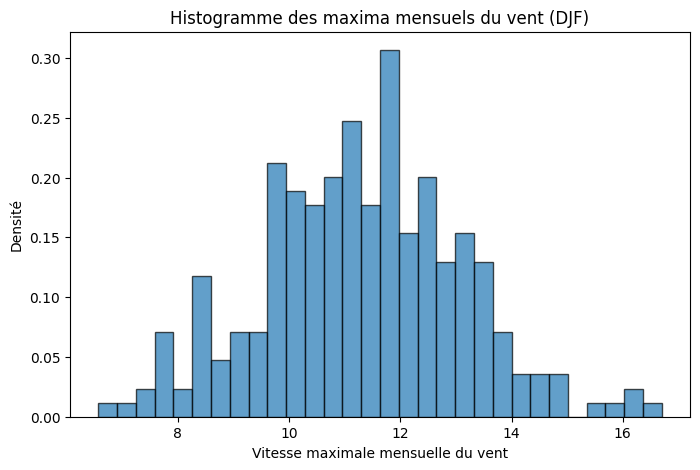

In [60]:
# Histogramme des maxima mensuels du vent (DJF)
plt.figure(figsize=(8,5))

plt.hist(Y_max_month, bins=30, density=True,
         edgecolor='black', alpha=0.7)

plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité")
plt.title("Histogramme des maxima mensuels du vent (DJF)")
plt.show()


### 2.Normale max mensuel

Test Shapiro-Wilk :
  statistique = 0.9951918799154564
  p-value     = 0.6249944702885792 

Test KS (paramètres estimés) :
  statistique = 0.02782449208775295
  p-value     = 0.9874416399519409


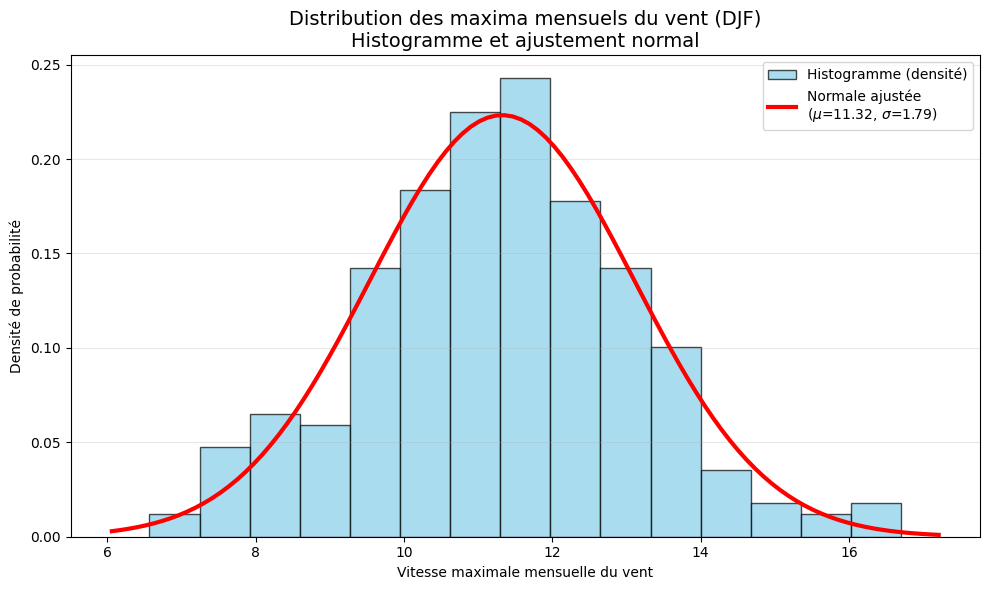

In [61]:
# Tracé de l'histogramme en densité des maxima mensuels du vent
plt.figure(figsize=(10,6))

# Nombre de bins
bins = int(np.sqrt(len(Y_max_month[:-1])))

plt.hist(Y_max_month[:-1], bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (densité)')

# Ajustement à la loi normale
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)
mu, sigma = norm.fit(Y_max_month[:-1])

plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée\n($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(Y_max_month[:-1])
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(Y_max_month[:-1], 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Labels et mise en forme
plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des maxima mensuels du vent (DJF)\nHistogramme et ajustement normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.Gamma et Beta pour max vent mensuel

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


 Gamma 
alpha = 39.00003031192499
scale = 0.29033692868128536
KS p-value = 0.6135571590406756

 Beta 
a = 465.30029243533454  b = 9981221.920106808
loc = -27.26499203092026  scale = 827795.100235007
KS p-value = 0.9296000101482544


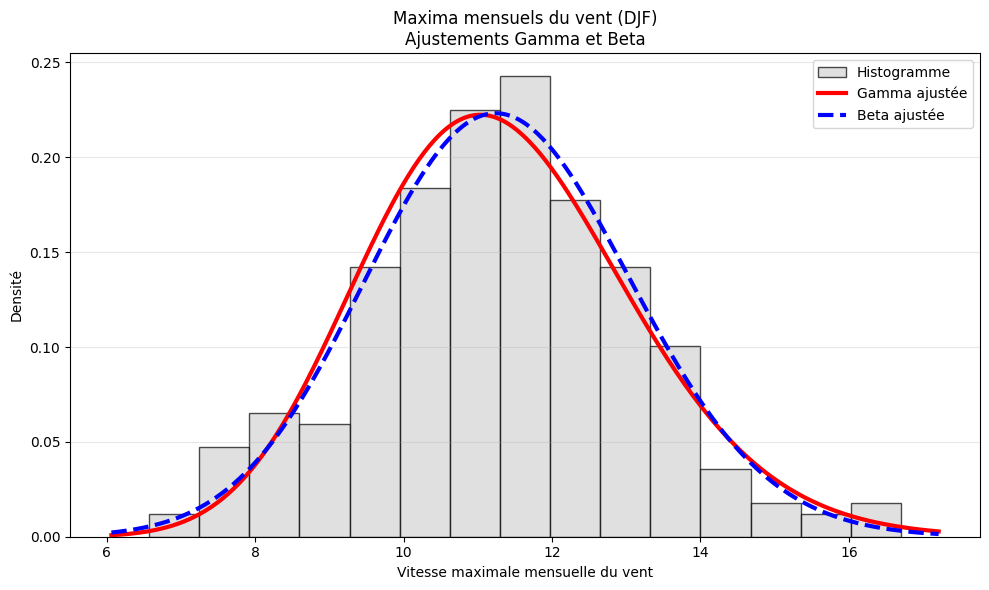

In [62]:
# Données : maxima mensuels du vent
Z = Y_max_month[:-1]   # on enlève la dernière si besoin

# Histogramme
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Z)))

plt.hist(Z, bins=bins, density=True,
         color='lightgrey', edgecolor='black', alpha=0.7,
         label='Histogramme')

xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)

# GAMMA
Z_pos = Z[Z > 0]                           # Gamma → valeurs positives
alpha, loc_g, scale_g = gamma.fit(Z_pos, floc=0)

plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=scale_g),
         'r-', lw=3, label='Gamma ajustée')

# p-value KS Gamma
ks_g, p_g = kstest(Z_pos, 'gamma', args=(alpha, 0, scale_g))

# BETA
a, b, loc_b, scale_b = beta_dist.fit(Z)

plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc_b, scale=scale_b),
         'b--', lw=3, label='Beta ajustée')

# p-value KS Beta
ks_b, p_b = kstest(Z, 'beta', args=(a, b, loc_b, scale_b))

# Résultats statistiques
print(" Gamma ")
print("alpha =", alpha)
print("scale =", scale_g)
print("KS p-value =", p_g)

print("\n Beta ")
print("a =", a, " b =", b)
print("loc =", loc_b, " scale =", scale_b)
print("KS p-value =", p_b)
# Plot final
plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité")
plt.title("Maxima mensuels du vent (DJF)\nAjustements Gamma et Beta")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.GEV max vent mensuel

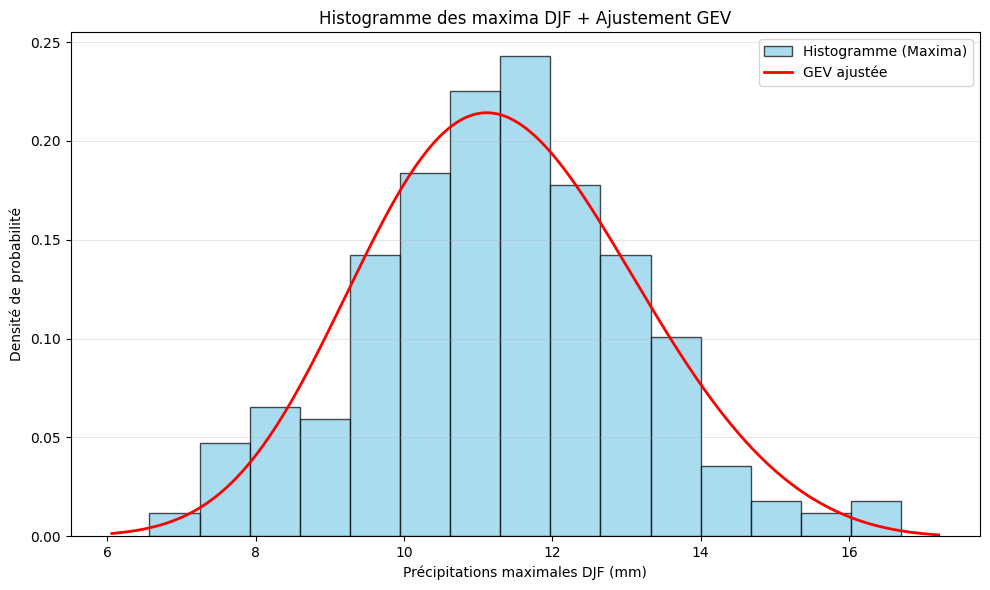

Paramètres GEV : shape(c)=0.237, loc=10.7, scale=1.8


In [63]:
# Ajustement GEV
cw1, locw1, scalew1 = genextreme.fit(Y_max_month[:-1])

# Histogramme des maxima
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Y_max_month[:-1])))
plt.hist(Y_max_month[:-1], bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (Maxima)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, cw1, locw1, scalew1), 'r-', lw=2, label='GEV ajustée')

plt.xlabel("Précipitations maximales DJF (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Histogramme des maxima DJF + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Paramètres GEV
print(f"Paramètres GEV : shape(c)={cw1:.3f}, loc={locw1:.1f}, scale={scalew1:.1f}")


In [64]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(cw1, loc=locw1, scale=scalew1).cdf(x)

# KS-test
ks_stat, ks_p = kstest(Y_max_month[:-1], gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.03485546255034422
  p-value     = 0.9111305273562189


### 5.GPD sur les moyennes de vent mensuelles

In [65]:
# Moyenne par mois (année–mois)
Y_moy_mois_val = Y.groupby(year_month).mean()

# Maintenant c’est un DataArray 1D
print(Y_moy_mois_val.shape)

(251,)


Nombre d'excès : 25


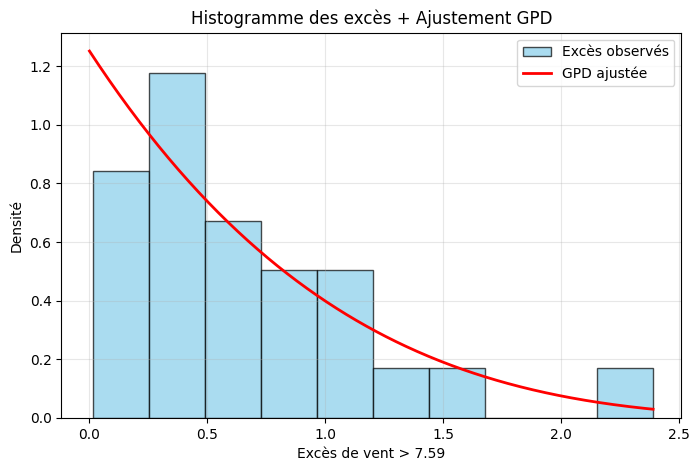

Test KS (GPD ajustée)
  Statistique = 0.1351564671725246
  p-value     = 0.7013803638236824
Log-vraisemblance = -14.01591957490643
AIC GPD = 32.03183914981286
Paramètres GPD : shape=-0.215, scale=0.799


In [66]:
# 1. Seuil (70e percentile)
Y_np = np.asarray(Y_moy_mois_val)
Y_np = Y_np[np.isfinite(Y_np)]

seuil = np.percentile(Y_np, threshold)

# Excès
exceedances_YM = Y_np[Y_np > seuil] - seuil
print("Nombre d'excès :", len(exceedances_YM))

# 2. Ajustement GPD
c5, loc5, scale5 = genpareto.fit(exceedances_YM, floc=0)

# 3. Histogramme + GPD
plt.figure(figsize=(8,5))
plt.hist(exceedances_YM, bins=10, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Excès observés')

xx = np.linspace(0, exceedances_YM.max(), 400)
plt.plot(xx, genpareto.pdf(xx, c5, loc=0, scale=scale5),
         'r-', lw=2, label='GPD ajustée')

plt.xlabel(f"Excès de vent > {seuil:.2f}")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Test KS
ks_stat, ks_p = kstest(
    exceedances_YM,
    lambda x: genpareto.cdf(x, c5, loc=0, scale=scale5)
)

print("Test KS (GPD ajustée)")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# 5. Log-vraisemblance et AIC
logL = np.sum(genpareto.logpdf(exceedances_YM, c5, loc=0, scale=scale5))
AIC_gpd = 2*2 - 2*logL   # k = 2 (shape + scale, loc fixé)

print("Log-vraisemblance =", logL)
print("AIC GPD =", AIC_gpd)

# 6. Paramètres
print(f"Paramètres GPD : shape={c5:.3f}, scale={scale5:.3f}")


##**E) Tableau recapitulatif des tests => Valider distribution**

In [67]:
import numpy as np
from scipy.stats import norm, gamma, beta as beta_dist, shapiro, kstest
from scipy.stats import genextreme, genpareto

def test_distributions(data, var_name, gpd_threshold=None):
    results = []

    data = np.asarray(data)
    data = data[np.isfinite(data)]

    # Normale
    mu, sigma = norm.fit(data)
    logL = np.sum(norm.logpdf(data, mu, sigma))
    AIC = 2*2 - 2*logL

    ks_stat, ks_p = kstest(data, 'norm', args=(mu, sigma))
    sh_stat, sh_p = shapiro(data[:5000])

    results.append([var_name, "Normale", ks_p, sh_p, AIC])

    # Gamma (positives)
    data_pos = data[data > 0]
    a, loc, scale = gamma.fit(data_pos, floc=0)
    logL = np.sum(gamma.logpdf(data_pos, a, 0, scale))
    AIC = 2*2 - 2*logL

    ks_stat, ks_p = kstest(data_pos, 'gamma', args=(a, 0, scale))

    results.append([var_name, "Gamma", ks_p, None, AIC])

    # Beta
    a, b, loc, scale = beta_dist.fit(data)
    logL = np.sum(beta_dist.logpdf(data, a, b, loc, scale))
    AIC = 2*4 - 2*logL   # a, b, loc, scale

    ks_stat, ks_p = kstest(data, 'beta', args=(a, b, loc, scale))

    results.append([var_name, "Beta", ks_p, None, AIC])

    # GEV (pour maxima)
    c, loc, scale = genextreme.fit(data)
    logL = np.sum(genextreme.logpdf(data, c, loc, scale))
    AIC = 2*3 - 2*logL

    ks_stat, ks_p = kstest(data, 'genextreme', args=(c, loc, scale))

    results.append([var_name, "GEV", ks_p, None, AIC])

    # GPD (POT)
    if gpd_threshold is not None:
        exceedances = data[data > gpd_threshold] - gpd_threshold

        if len(exceedances) > 20:  # sécurité
            c, loc, scale = genpareto.fit(exceedances, floc=0)
            logL = np.sum(genpareto.logpdf(exceedances, c, 0, scale))
            AIC = 2*2 - 2*logL

            ks_stat, ks_p = kstest(exceedances, 'genpareto', args=(c, 0, scale))

            results.append([var_name, "GPD", ks_p, None, AIC])

    return results


In [68]:
table_results = []

table_results += test_distributions(
    X,
    "Précipitations journalières DJF (X)",
    gpd_threshold=np.percentile(X, threshold)
)

table_results += test_distributions(
    Somme_mois,
    "Précipitations mensuelles DJF (Somme)",
    gpd_threshold=np.percentile(Somme_mois, threshold)
)

table_results += test_distributions(
    WinterPI,
    "Précipitations hivernales DJF (WPI)",
    gpd_threshold=np.percentile(WinterPI, threshold)
)

table_results += test_distributions(
    Y,
    "Vent moyen journalier DJF (Y)",
    gpd_threshold=np.percentile(Y, threshold)
)

table_results += test_distributions(
    Y_max_month,
    "Vent maximal mensuel DJF",
    gpd_threshold=np.percentile(Y_max_month, threshold)
)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [69]:
import pandas as pd

df_results = pd.DataFrame(
    table_results,
    columns=["Variable", "Loi", "KS p-value", "Shapiro p-value", "AIC"]
)

df_results


,Variable,Loi,KS p-value,Shapiro p-value,AIC
0,Précipitations journalières DJF (X),Normale,0.000000e+00,3.562874e-70,103698.450226
1,Précipitations journalières DJF (X),Gamma,1.043546e-04,NaN,83424.470588
2,Précipitations journalières DJF (X),Beta,0.000000e+00,NaN,90668.607686
3,Précipitations journalières DJF (X),GEV,1.622450e-65,NaN,88413.590715
4,Précipitations journalières DJF (X),GPD,7.029144e-01,NaN,9867.918040
5,Précipitations mensuelles DJF (Somme),Normale,1.273054e-01,9.660940e-05,4608.384388
6,Précipitations mensuelles DJF (Somme),Gamma,4.608138e-01,NaN,4591.451269
7,Précipitations mensuelles DJF (Somme),Beta,9.795036e-01,NaN,4586.874751
8,Précipitations mensuelles DJF (Somme),GEV,3.443246e-124,NaN,5838.587932
9,Précipitations mensuelles DJF (Somme),GPD,4.880574e-01,NaN,407.500798


# **IV/ Etude multivariée**

## **A) Etude de la dépendance X-Y**

### 1.Tracé du nuage de points des précipitations et des vents journaliers

In [70]:
df_X = X.to_dataframe(name='precip').reset_index().set_index('time')['precip']
df_Y = Y.to_dataframe(name='wind').reset_index().set_index('time')['wind']

# On joint les deux séries sur l'index temporel
df_joint = pd.concat([df_X, df_Y], axis=1, join='inner').dropna()

# vecteurs alignés
X_joint = df_joint['precip'].values
Y_joint = df_joint['wind'].values

print(f"Tous les jours sont conservés : {len(df_joint)==7550}")
print(df_X)
print(df_joint)
print(X_joint)

Tous les jours sont conservés : True
time
1940-01-01      0.023794
1940-01-02      0.000000
1940-01-03    338.097168
1940-01-04    130.484589
1940-01-05     13.185601
                 ...    
2023-02-24     48.115871
2023-02-25     11.824378
2023-02-26      1.189961
2023-02-27      2.132847
2023-02-28    187.348389
Name: precip, Length: 7550, dtype: float32
                precip      wind
time                            
1940-01-01    0.023794  7.834760
1940-01-02    0.000000  7.027803
1940-01-03  338.097168  6.503153
1940-01-04  130.484589  4.614581
1940-01-05   13.185601  3.163189
...                ...       ...
2023-02-24   48.115871  7.247035
2023-02-25   11.824378  6.912128
2023-02-26    1.189961  8.036705
2023-02-27    2.132847  7.903212
2023-02-28  187.348389  7.378880

[7550 rows x 2 columns]
[2.3794351e-02 0.0000000e+00 3.3809717e+02 ... 1.1899608e+00 2.1328471e+00
 1.8734839e+02]


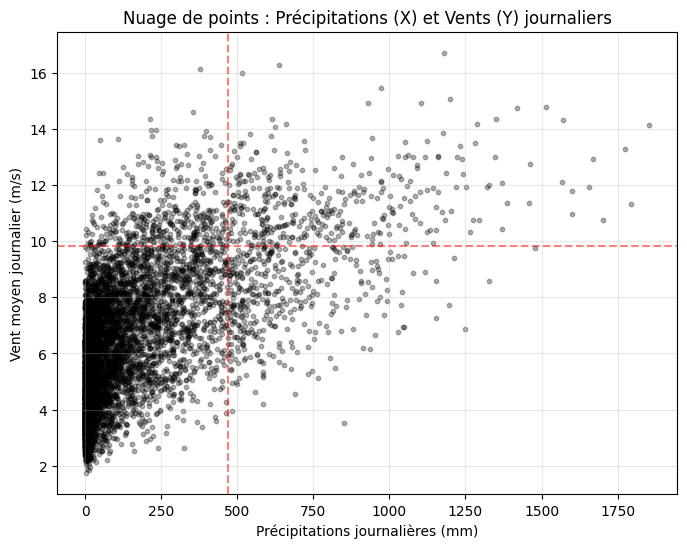

In [71]:
p = 90  # seuil à 90%
seuil_X = np.percentile(X_joint, p)
seuil_Y = np.percentile(Y_joint, p)

# Visualisation du Nuage de points
plt.figure(figsize=(8, 6))
plt.axvline(seuil_X, color='r', linestyle='--', alpha=0.5)
plt.axhline(seuil_Y, color='r', linestyle='--', alpha=0.5)
plt.scatter(X_joint, Y_joint, alpha=0.3, s=10, c='black', label='Observations')
plt.xlabel("Précipitations journalières (mm)")
plt.ylabel("Vent moyen journalier (m/s)")
plt.title("Nuage de points : Précipitations (X) et Vents (Y) journaliers")
plt.grid(alpha=0.3)
plt.show()

In [72]:
# Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(X_joint, Y_joint)
# Kendall (rangs, peu sensible aux valeurs extrêmes)
kendall_corr, p_val_k = st.kendalltau(X_joint, Y_joint)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(X_joint, Y_joint)

print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")

Pearson  (r)   : 0.627
Spearman (rho) : 0.658
Kendall  (tau) : 0.466


Conclusion : Les coefficients confirment une corrélation positive significative


***1. Une corrélation positive***

L'orientation générale du nuage va du bas-gauche vers le haut-droite.

* **Observation :** De manière générale, plus les précipitations (X) sont élevées, plus la vitesse du vent (Y) est élevée.
* **Confirmation :** Cela valide visuellement le coefficient de corrélation (Kendall , Spearman ).

***2. Le coin vide (asymétrie)***

La forme du nuage est **triangulaire** ou en forme d'éventail.

* **Coin inférieur droit (Vide) :** Il n'y a **aucun point** avec de très fortes précipitations ( mm cumulés) et un vent faible ( m/s).
* *Interprétation :* En hiver en Bretagne, les fortes pluies sont apportées par des dépressions dynamiques venant de l'Atlantique. Il est physiquement impossible d'avoir ce type de pluie sans le vent associé. (pas comme un phénomène type mousson)


* **Coin supérieur gauche (Peuplé) :** Il y a des points avec un vent fort ( m/s) mais peu de précipitations.
* *Interprétation physique :* Il est possible d'avoir des tempêtes "sèches" ou des coups de vent sans pluie massive, même si c'est moins fréquent que les tempêtes humides.



***3. La dépendance dans les extrêmes (Queue supérieure)***

A la droite du graphique:

* Dès que les précipitations deviennent extrêmes, le vent est **systématiquement fort** (il se concentre dans la partie haute, majoritairement au-dessus de 10 m/s).
* Cela indique une **forte dépendance de queue supérieure**. Les extrêmes des deux variables ont tendance à se produire simultanément (Clustering).
* C'est un argument fort pour l'utilisation de la **Copule de Gumbel**, qui est spécialisée pour modéliser ce genre de dépendance dans les maxima conjoints.

***4. La densité des données (Le "coeur" de la distribution)***

* La grande majorité des points (la tache noire dense) se situe entre 0 et 500 mm pour la pluie, et entre 4 et 10 m/s pour le vent.
* Cela rappelle que les événements extrêmes que nous étudions (les points gris dispersés vers la droite et le haut) sont rares par rapport au climat moyen, d'où l'importance d'utiliser la théorie des valeurs extrêmes (GPD/GEV) pour les marges.

***Conclusion***

Ce graphique illustre le concept d'**événement composé** : le risque d'inondation (lié à la pluie) est aggravé par le risque de submersion ou de dégâts éoliens (lié au vent) car les deux surviennent souvent en même temps.

**Prochaine étape suggérée :** Lancer le code de comparaison des copules Gumbel vs Clayton vs Gauss. Ce graphique suggère fortement que **Gumbel** sera le meilleur modèle car il capture bien cette "pointe" vers le haut-droite, contrairement à la Gaussienne qui chercherait une forme elliptique plus symétrique.

### 2.Etude de la copule empirique (Approche par les rangs)

True
[0.73831281 0.63872335 0.56456099 ... 0.75976692 0.74652364 0.68229374]


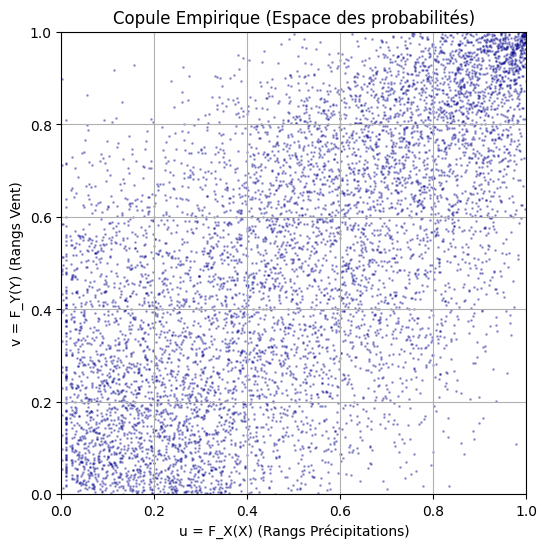

In [73]:
# Comme les lois marginales sont complexes (GPD en queue, etc.), on passe
# dans l'espace des rangs (espace uniforme [0,1], cdf empirique) pour voir la structure de dépendance pure.

# Transformation en pseudo-observations (u, v)
u = st.rankdata(X_joint) / (len(X_joint) + 1)
v = st.rankdata(Y_joint) / (len(Y_joint) + 1)

print(len(u)==len(v))
print(v)

plt.figure(figsize=(6, 6))
plt.scatter(u, v, s=1, alpha=0.3, color='darkblue')
plt.xlabel("u = F_X(X) (Rangs Précipitations)")
plt.ylabel("v = F_Y(Y) (Rangs Vent)")
plt.title("Copule Empirique (Espace des probabilités)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Interprétation visuelle :
# - Si les points sont partout : Indépendance.
# - Si les points se regroupent le long de la diagonale (bas-gauche vers haut-droite) : Dépendance positive.
# - Regardez le coin haut-droit (1,1) : Y a-t-il une concentration ? (Dépendance de queue supérieure).

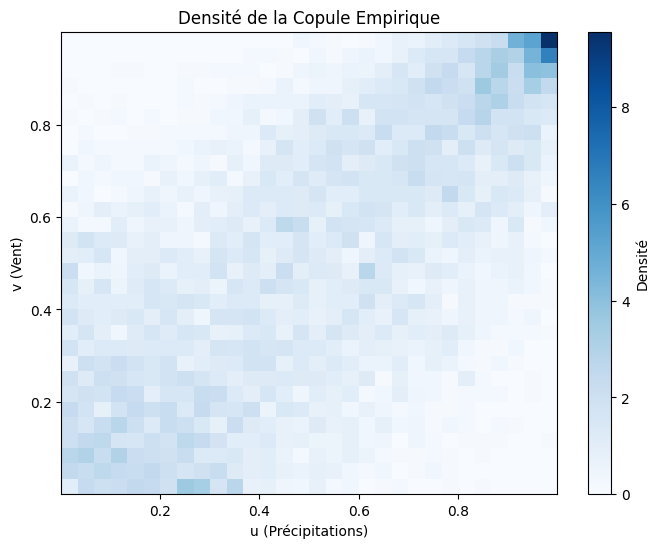

In [74]:
# La densité des copules (heatmap)
def heatmap(u, v, n_bins=100):
    n = len(u)


    plt.figure(figsize=(8, 6))
    plt.hist2d(u, v, bins=30, cmap="Blues", density=True)
    plt.colorbar(label="Densité")
    plt.xlabel("u (Précipitations)")
    plt.ylabel("v (Vent)")
    plt.title("Densité de la Copule Empirique")
    plt.show()

heatmap(u, v)

Ce graphique montre la **structure de dépendance pure** (en probabilités/rangs), débarrassée des unités et des formes de distribution.

C'est une transformation du premier. On a remplacé chaque valeur par son "rang" (entre 0 et 1).

*  u≈0: Jour sec  / u≈1: Jour pluvieux
*  v≈0: Jour sans vent /  v≈1: Jour plus venteux

Description du graphe:

* **Concentration sur la diagonale :** Les points bleus ne sont pas éparpillés au hasard (ce qui signifierait l'indépendance). Ils ont tendance à suivre la ligne .
* **Le Cluster en (1, 1) :** signifie que les jours les plus pluvieux sont presque systématiquement les jours les plus venteux = Dépendance de Queue Supérieure (Upper Tail Dependence).

* La dépendance est plus forte dans le coin (1,1) que dans le coin (0,1) ou (1,0).

***Conclusion***

1. On ne peut pas utiliser une loi Gaussienne classique (car elle suppose une symétrie et pas de dépendance de queue forte).
2. La concentration intense dans le coin (1,1) de la Copule Empirique est la signature typique d'une **Copule de Gumbel**.

### 3.Calcul Observé/Independant:

In [75]:
# # Calcul de la probabilité conjointe d'un événement extrême (Concurrent extremes)
# # Exemple : Quelle est la probabilité d'avoir SIMULTANEMENT :
# # Pluie > percentile 95 ET Vent > percentile 95
# seuil_u = 0.95
# seuil_v = 0.95

# p_joint_extreme = np.sum((u > seuil_u) & (v > seuil_v)) / len(u)
# p_theoretical_indep = (1 - seuil_u) * (1 - seuil_v)

# print(f"Analyse des extrêmes conjoints (Seuil 95%):")
# print(f"Probabilité théorique (si indépendants) : {p_theoretical_indep:.4f}")
# print(f"Probabilité empirique observée          : {p_joint_extreme:.4f}")

# ratio = p_joint_extreme / p_theoretical_indep
# print(f"Ratio (Obsevée / Indep) : {ratio:.2f}")
# if ratio > 1:
#     print("Conclusion : Le ratio est > 1, donc les extrêmes de pluie et de vent ont tendance à arriver en même temps (Clustering).")
# else:
#     print("Conclusion : Pas de dépendance particulière dans les extrêmes.")

***1. Hypothèse d'Indépendance***

* **Calcul :** On regarde les événements extrêmes, ceux qui dépassent le seuil de 95%. Si la pluie et le vent n'avaient aucun lien, la probabilité d'avoir les deux en même temps serait simplement le produit des probabilités soit 0,05×0,05= 0,25%


* **Signification :** Avec cette hypothèse, une tempête combinée (pluie + vent extrêmes) est un événement très rare.

***2. La Réalité Observée (L'empirique)***

* **Chiffre :** 1,92%
* **Signification :** Dans les données historiques, ce scénario arrive en réalité **près de 2% du temps**, et non 0,25%. C'est donc beaucoup plus fréquent que prévu par le modèle indépendant.

***3. Le Ratio***
Le Facteur d'Aggravation: 7,68

* **Interprétation :** Il y a **près de 8 fois plus de chances** de subir une tempête majeure que si les deux phénomènes étaient indépendants.


***4. Conclusion Physique : "Compound Events"***

Ce résultat confirme statistiquement la réalité météorologique de la Bretagne en hiver :

* Les **dépressions atlantiques** sont des systèmes physiques qui apportent **à la fois** des basses pressions (donc du vent fort) et des fronts humides (donc de la pluie intense).

Cela prouve mathématiquement que considérer la pluie et le vent comme indépendants serait une grave erreur pour l'évaluation des risques en Bretagne.

 = **forte dépendance de queue supérieure**. Les extrêmes s'attirent. Cela justifie l'utilisation d'une **Copule de Gumbel** (spécialisée dans les extrêmes simultanés) pour modéliser le risque conjoint.

###4.Calcul en séparant queue de distribution GPD :

Seuils définis : X > 469.08 | Y > 9.84
755
367


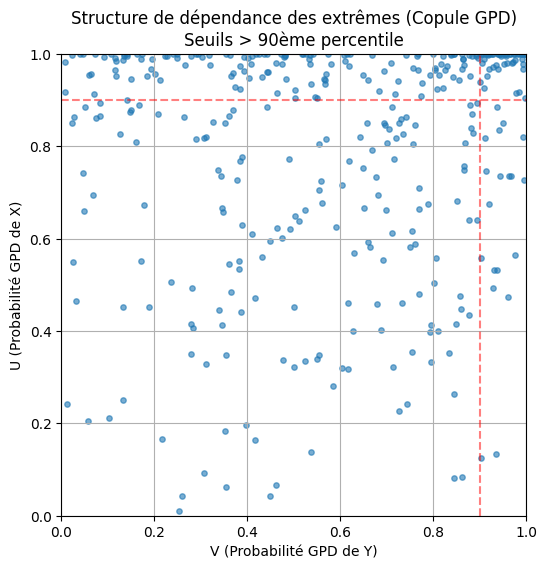

In [76]:

def gpd_transform_tail(data, threshold, gpd_params):
    """
    1. Isole les valeurs > seuil.
    2. Soustrait le seuil pour avoir les excès.
    3. Transforme les excès en probabilités [0, 1] via la CDF de la GPD.
    """
    data = np.array(data)
    xi, loc, sigma = gpd_params # xi (shape), loc (0), sigma (scale)

    # 1. Masque : on ne garde que ce qui dépasse le seuil
    mask_tail = data > threshold

    # 2. Excès : GPD travaille sur (Valeur - Seuil)
    excess = data[mask_tail] - threshold

    # 3. Transformation en probabilités (0 à 1)
    tail_probs = genpareto.cdf(excess, xi, loc=0, scale=sigma)

    return mask_tail, tail_probs

# Définition correcte des seuils pour la sélection des données

t = 90  # seuil à 90%
seuil_X = np.percentile(X_joint, t)
seuil_Y = np.percentile(Y_joint, t)

print(f"Seuils définis : X > {seuil_X:.2f} | Y > {seuil_Y:.2f}")

# Transformation Marginale GPD
# On récupère U et V qui sont les probabilités GPD (entre 0 et 1)

mask_X, U_gpd = gpd_transform_tail(X_joint, seuil_X, (c4, loc4, scale4))
mask_Y, V_gpd = gpd_transform_tail(Y_joint, seuil_Y, (c5, loc5, scale5))

#  Intersection (Extraction des extrêmes conjoints)
# On cherche les indices où X ET Y dépassent TOUS LES DEUX le seuil
mask_conjoint = mask_X & mask_Y

# mask_conjoint[mask_X] sélectionne, PARMI les extrêmes de X, ceux où Y est aussi extrême.
U_conjoint = U_gpd[mask_conjoint[mask_X]]
V_conjoint = V_gpd[mask_conjoint[mask_Y]]

print(len(U_gpd))

print(len(U_conjoint))

#  4. Visualisation de la dépendance de queue
plt.figure(figsize=(6, 6))
plt.scatter(U_conjoint, V_conjoint, s=15, alpha=0.6)

plt.title(f"Structure de dépendance des extrêmes (Copule GPD)\nSeuils > {p}ème percentile")
plt.xlabel("V (Probabilité GPD de Y)")
plt.ylabel("U (Probabilité GPD de X)")
# Zoom sur le coin supérieur droit (les extrêmes)
plt.axvline(0.90, color='r', linestyle='--', alpha=0.5)
plt.axhline(0.90, color='r', linestyle='--', alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [77]:
# création x et y au dessus du seuil.
X_extremes = X_joint[mask_X]
Y_extremes = Y_joint[mask_Y]

X_conjoint = X_joint[mask_conjoint]
Y_conjoint = Y_joint[mask_conjoint]

# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(X_conjoint, Y_conjoint)

# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(X_conjoint, Y_conjoint)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(X_conjoint, Y_conjoint)
print ("extremes")
print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")



extremes
Pearson  (r)   : 0.241
Spearman (rho) : 0.151
Kendall  (tau) : 0.105


In [78]:
u = U_conjoint
v = V_conjoint
# Définition des bornes du carré
u_min = 0.90
v_min = 0.80

# Masque des points dans le carré (coin supérieur droit)
mask_carre = (u >= u_min) & (v >= v_min)

# Nombre de points
nb_points_carre = np.sum(mask_carre)

print("Nombre de points dans le carré encadré :", nb_points_carre)
print("Nombre total d'extrêmes conjoints :", len(u))
print("Proportion dans le carré :", nb_points_carre / len(u))

Nombre de points dans le carré encadré : 55
Nombre total d'extrêmes conjoints : 367
Proportion dans le carré : 0.14986376021798364


In [79]:
print("u max:", u.max(), "  v_gpd max:", v.max())
print("top 5 u:", np.sort(u)[-5:])
print("top 5 v:", np.sort(v)[-5:])

u max: 0.997781216972192   v_gpd max: 1.0
top 5 u: [0.99431586 0.99517068 0.99664655 0.99698969 0.99778122]
top 5 v: [1. 1. 1. 1. 1.]


In [80]:
# 4. Analyse des extrêmes corrigée
# On recalcule la probabilité conjointe avec les vecteurs u et v
prob_joint_extreme = np.sum((u > u_min) & (v > v_min)) / len(u)
print(f"Probabilité conjointe (extrêmes > 90%) avec GPD : {prob_joint_extreme:.5f}")

Probabilité conjointe (extrêmes > 90%) avec GPD : 0.14986


In [81]:
# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(u,v)
# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(u,v)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(u,v)

print(f"Pearson  (r)   : {pearson_corr:.3f}")
print(f"Spearman (rho) : {spearman_corr:.3f}")
print(f"Kendall  (tau) : {kendall_corr:.3f}")

Pearson  (r)   : 0.097
Spearman (rho) : 0.151
Kendall  (tau) : 0.105


## **B) La Copule:**

### 1.Visualisation des copules:

Rappel du cours: (a priori Gumbel pour les upper tails mieux)

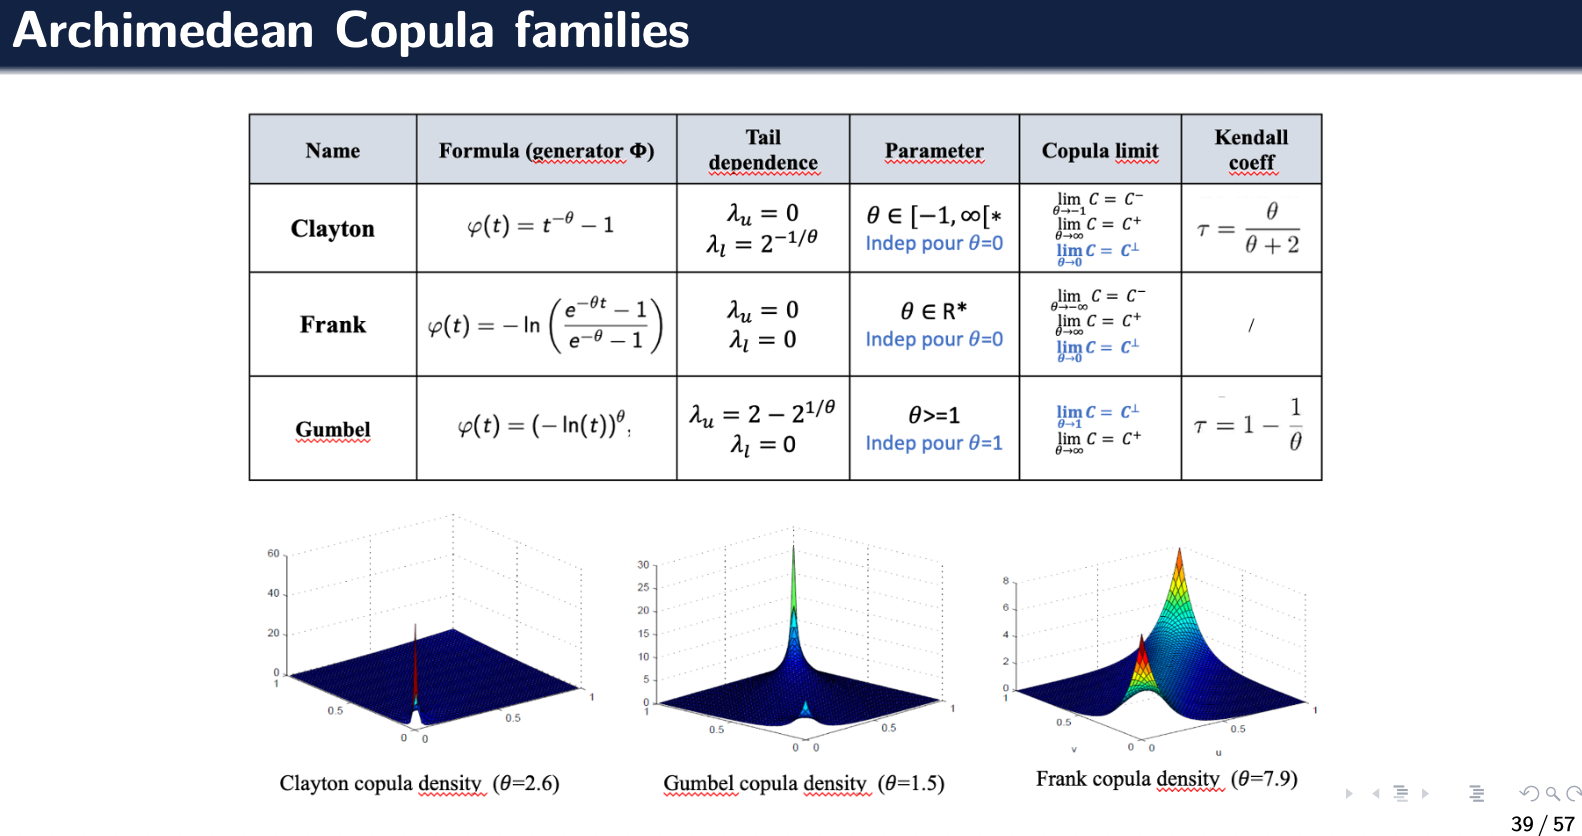

On compare quand même les copules archimédiennes:
Pour ça, on calcule les paramètres de chaque copule avec les formules ci-dessus, puis on trouve les pdfs et on trace les graphiques données et iso

In [83]:
tau = kendall_corr

In [84]:
# 1. Récupération du Tau de Kendall calculé précédemment
print(f"Tau de Kendall utilisé pour l'estimation : {tau:.4f}")
tau = kendall_corr
# 2. Estimation des paramètres (Méthode des Moments via Kendall's Tau)

# Copule de Gumbel (Dépendance de queue supérieure, extrêmes forts)
# Relation : tau = 1 - 1/theta
theta_gumbel = 1 / (1 - tau)
print(f"Paramètre Gumbel estimé (theta) : {theta_gumbel:.4f}")

# Copule de Clayton (Dépendance de queue inférieure, valeurs faibles)
# Relation : tau = theta / (theta + 2)
theta_clayton = 2 * tau / (1 - tau)
print(f"Paramètre Clayton estimé (theta) : {theta_clayton:.4f}")

# Copule Gaussienne (Symétrique)
# Relation : r = sin(pi/2 * tau)
rho_gauss = np.sin(np.pi / 2 * tau)
print(f"Paramètre Gaussien estimé (rho) : {rho_gauss:.4f}")
tau = float(np.clip(tau, -0.999, 0.999))

if tau <= 0:
    print("Attention : tau<=0, Clayton/Gumbel (standard) ne sont pas adaptés.")
else:
    theta_gumbel = 1 / (1 - tau)
    theta_clayton = 2 * tau / (1 - tau)

rho_gauss = np.sin(np.pi/2 * tau)


Tau de Kendall utilisé pour l'estimation : 0.1050
Paramètre Gumbel estimé (theta) : 1.1173
Paramètre Clayton estimé (theta) : 0.2346
Paramètre Gaussien estimé (rho) : 0.1641


In [85]:
# 3. Simulation pour Comparaison Visuelle
# On génère des données artificielles avec ces lois pour voir laquelle ressemble à nos données

# Pour simplifier l'affichage sans librairie 'copulae' lourde,
# nous allons tracer les isolignes de densité théorique sur les données empiriques (Rangs).

# Grille pour les contours
u_grid = np.linspace(0.01, 0.99, 100)
v_grid = np.linspace(0.01, 0.99, 100)
U_grid, V_grid = np.meshgrid(u_grid, v_grid)

# Formules des Densités de Copules (PDF)

def pdf_gumbel(u, v, theta, eps=1e-12):
    """
    Densité de la copule de Gumbel (theta >= 1)
    Formule archimédienne:
        c(u,v) = φ''(C) φ'(u) φ'(v) / (φ'(C))^3
    avec φ(t)=(-ln t)^theta, C = φ^{-1}(φ(u)+φ(v)).
    """
    if theta < 1:
        raise ValueError("Gumbel: theta must be >= 1")

    u = np.clip(np.asarray(u), eps, 1 - eps)
    v = np.clip(np.asarray(v), eps, 1 - eps)

    # φ(t) = (-ln t)^θ
    def phi(t):
        L = -np.log(t)
        return np.power(L, theta)

    # φ^{-1}(s) = exp(-(s)^{1/θ})
    def phi_inv(s):
        return np.exp(-np.power(s, 1/theta))

    # φ'(t) = -θ (-ln t)^{θ-1} / t
    def phi_p(t):
        L = -np.log(t)
        return -(theta * np.power(L, theta - 1)) / t

    # φ''(t) = θ/t^2 * [ (θ-1)(-ln t)^{θ-2} + (-ln t)^{θ-1} ]
    def phi_pp(t):
        L = -np.log(t)
        return (theta / (t**2)) * ((theta - 1) * np.power(L, theta - 2) + np.power(L, theta - 1))

    s = phi(u) + phi(v)
    C = phi_inv(s)

    num = phi_pp(C) * phi_p(u) * phi_p(v)
    den = np.power(phi_p(C), 3)

    c = num / np.clip(den, 1e-300, np.inf)
    return np.clip(c, 1e-300, np.inf)


def pdf_clayton(u, v, theta):
    u = np.clip(u, 1e-12, 1-1e-12)
    v = np.clip(v, 1e-12, 1-1e-12)
    val = (u**(-theta) + v**(-theta) - 1)**(-1/theta - 2)
    return (1 + theta) * (u * v)**(-theta - 1) * val

def pdf_gauss(u, v, rho, eps=1e-12):
    u = np.clip(u, eps, 1-eps)
    v = np.clip(v, eps, 1-eps)
    rho = float(np.clip(rho, -0.9999, 0.9999))

    x = norm.ppf(u)
    y = norm.ppf(v)

    den = np.sqrt(1 - rho**2)
    expo = - (rho**2 * (x**2 + y**2) - 2*rho*x*y) / (2*(1-rho**2))
    return np.exp(expo) / den


In [86]:
# u, v = extrêmes conjoints GPD
u = np.asarray(U_conjoint)
v = np.asarray(V_conjoint)

mask = np.isfinite(u) & np.isfinite(v)
u = u[mask]; v = v[mask]

### 3.Joe copula

nb points tempêtes (rectangle) = 50
Tau Kendall (sur u,v) = 0.1050 (p=0.0027)
theta_joe = 1.370
LL_joe (global) = 254137.61  | AIC_joe (global) = -508273.22
LL_joe (rect)   = 34369.85 | AIC_joe (rect)   = -68737.70
lambda_u (Joe) = 0.342 ; lambda_l = 0.000


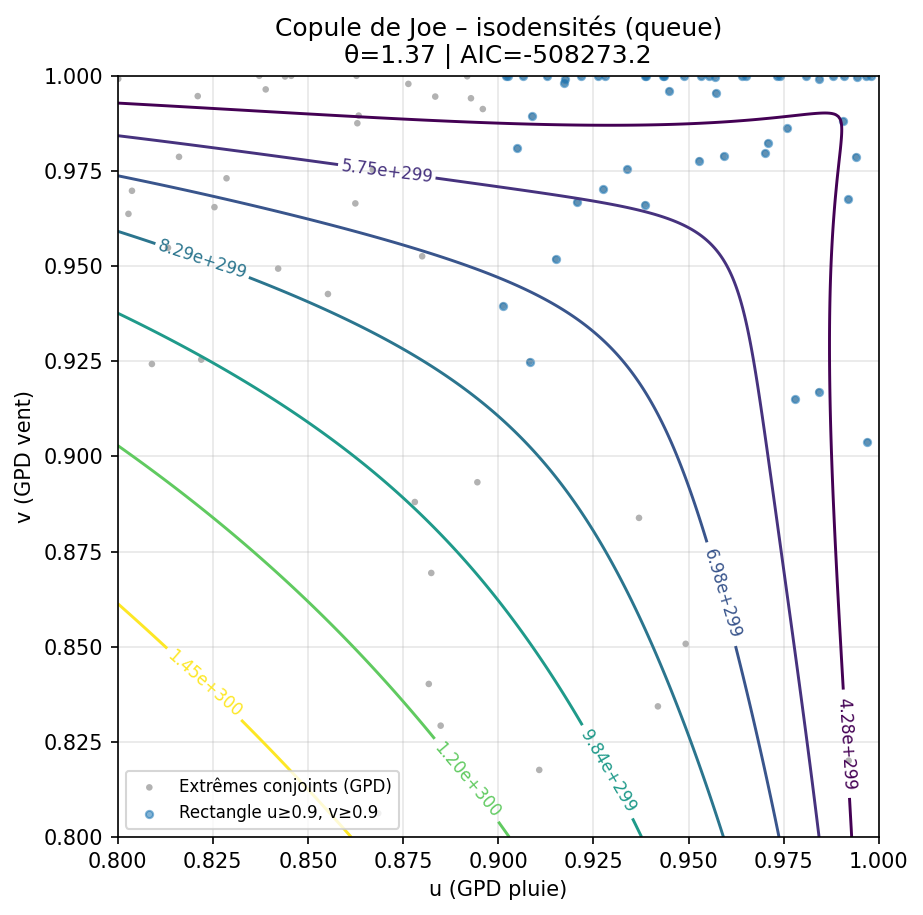

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.optimize import brentq

# -----------------------------
# 0) Utilitaires
# -----------------------------
def clip01(a, eps=1e-12):
    return np.clip(np.asarray(a), eps, 1 - eps)

def loglik(pdf_vals):
    pdf_vals = np.asarray(pdf_vals)
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)
    return float(np.sum(np.log(pdf_vals)))

def AIC_from_LL(LL, k):
    # AIC = 2k - 2 logL
    return 2*k - 2*LL

# -----------------------------
# 1) Densité copule de Joe (formule archimédienne fiable)
# -----------------------------
def pdf_joe(u, v, theta, eps=1e-12):
    """
    Joe copula density (theta >= 1)
    c(u,v) = φ''(C) φ'(u) φ'(v) / (φ'(C))^3
    with φ(t) = -log(1 - (1-t)^theta), C = φ^{-1}(φ(u)+φ(v))
    """
    if theta < 1:
        raise ValueError("Joe: theta must be >= 1")

    u = clip01(u, eps); v = clip01(v, eps)

    def phi(t):
        b = 1 - t
        return -np.log(1 - np.power(b, theta))

    def phi_inv(s):
        return 1 - np.power(1 - np.exp(-s), 1/theta)

    def phi_p(t):
        b = 1 - t
        den = 1 - np.power(b, theta)
        num = -theta * np.power(b, theta - 1)
        return num / den  # negative

    def phi_pp(t):
        b = 1 - t
        den = 1 - np.power(b, theta)
        termA = theta * (theta - 1) * np.power(b, theta - 2) * den
        termB = (theta**2) * np.power(b, 2*theta - 2)
        return (termA + termB) / np.power(den, 2)

    s = phi(u) + phi(v)
    C = phi_inv(s)

    num = phi_pp(C) * phi_p(u) * phi_p(v)
    den = np.power(phi_p(C), 3)
    c = num / np.clip(den, 1e-300, np.inf)
    return np.clip(c, 1e-300, np.inf)

# -----------------------------
# 2) Relation tau(theta) pour Joe + inversion
# -----------------------------
def kendall_tau_joe(theta, K=5000):
    # tau(theta) = 1 - (4/theta) * sum_{k>=1} 1/(k(k+1)(k+theta))
    k = np.arange(1, K + 1, dtype=float)
    series = np.sum(1.0 / (k * (k + 1) * (k + theta)))
    return 1.0 - (4.0 / theta) * series

def invert_tau_joe(tau_target):
    if tau_target <= 0:
        raise ValueError("Joe modélise une dépendance positive : il faut tau > 0.")
    f = lambda th: kendall_tau_joe(th) - tau_target
    return brentq(f, 1.000001, 80.0)  # theta >= 1

# -----------------------------
# 3) Données : u, v (extrêmes conjoints GPD)
# -----------------------------
eps = 1e-12
u = clip01(u, eps)
v = clip01(v, eps)

mask = np.isfinite(u) & np.isfinite(v)
u = u[mask]; v = v[mask]

# Rectangle "tempêtes" (optionnel)
u_min = 0.90
v_min = 0.90
mask_storm = (u >= u_min) & (v >= v_min)
u_storm = u[mask_storm]
v_storm = v[mask_storm]
print("nb points tempêtes (rectangle) =", len(u_storm))

# -----------------------------
# 4) Estimation theta Joe (via Kendall tau)
# -----------------------------
tau, pval = kendalltau(u, v)
print(f"Tau Kendall (sur u,v) = {tau:.4f} (p={pval:.2g})")

theta_joe = invert_tau_joe(tau)
print(f"theta_joe = {theta_joe:.3f}")

# -----------------------------
# 5) Log-vraisemblance + AIC
# -----------------------------
LL_joe = loglik(pdf_joe(u, v, theta_joe))
k_joe = 1  # Joe a 1 paramètre theta
AIC_joe = AIC_from_LL(LL_joe, k_joe)

LL_joe_tail = np.nan
AIC_joe_tail = np.nan
if len(u_storm) > 0:
    LL_joe_tail = loglik(pdf_joe(u_storm, v_storm, theta_joe))
    AIC_joe_tail = AIC_from_LL(LL_joe_tail, k_joe)

print(f"LL_joe (global) = {LL_joe:.2f}  | AIC_joe (global) = {AIC_joe:.2f}")
print(f"LL_joe (rect)   = {LL_joe_tail:.2f} | AIC_joe (rect)   = {AIC_joe_tail:.2f}")

# Dépendance de queue théorique (Joe)
lambda_u = 2 - 2**(1/theta_joe)
print(f"lambda_u (Joe) = {lambda_u:.3f} ; lambda_l = 0.000")

# -----------------------------
# 6) Tracé : isodensités dans la queue + points
# -----------------------------
grid = np.linspace(0.8, 0.999, 350)
U_grid, V_grid = np.meshgrid(grid, grid)

Z = pdf_joe(U_grid, V_grid, theta_joe)

levels = np.quantile(Z, [0.10, 0.25, 0.40, 0.55, 0.70, 0.85, 0.95])
levels = np.unique(levels)
levels = levels[(levels > Z.min()) & (levels < Z.max())]

fig, ax = plt.subplots(figsize=(6.8, 6.2), dpi=150)
cs = ax.contour(U_grid, V_grid, Z, levels=levels, linewidths=1.4)
ax.clabel(cs, fmt="%.2e", fontsize=8)

ax.scatter(u, v, s=10, alpha=0.30, color="black", edgecolors="none", label="Extrêmes conjoints (GPD)")
ax.scatter(u_storm, v_storm, s=12, alpha=0.55, label=f"Rectangle u≥{u_min}, v≥{v_min}")

ax.set_aspect("equal")
ax.set_xlim(0.8, 1.0)
ax.set_ylim(0.8, 1.0)
ax.set_xlabel("u (GPD pluie)")
ax.set_ylabel("v (GPD vent)")
ax.set_title(f"Copule de Joe – isodensités (queue)\nθ={theta_joe:.2f} | AIC={AIC_joe:.1f}")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower left", fontsize=8)

plt.tight_layout()
plt.show()


### 4.Student Copula

In [88]:
# 1) Tau empirique sur (u,v)
tau, pval = kendalltau(u, v)

# Student copula (copule elliptique) : tau = 2/pi * arcsin(rho)  => rho = sin(pi*tau/2)
rho_student = float(np.sin((np.pi / 2) * tau))
rho_student = float(np.clip(rho_student, -0.9999, 0.9999))


print(f"Student: τ={tau:.3f} (p={pval:.2g})  ->  ρ={rho_student:.3f}")

Student: τ=0.105 (p=0.0027)  ->  ρ=0.164


In [89]:
import numpy as np
from scipy.special import gammaln
from scipy import stats as st

def clip01(a, eps=1e-12):
    return np.clip(np.asarray(a), eps, 1 - eps)

def biv_t_pdf_xy(x, y, nu, rho):
    """
    pdf t bivariée sur (x,y) où x,y peuvent être arrays de même forme
    Corr [[1,rho],[rho,1]]
    """
    rho = float(np.clip(rho, -0.9999, 0.9999))
    det = 1 - rho**2

    Q = (x**2 - 2*rho*x*y + y**2) / det

    logC = (gammaln((nu + 2) / 2) - gammaln(nu / 2)
            - np.log(nu * np.pi) - 0.5 * np.log(det))
    logpdf = logC - ((nu + 2) / 2) * np.log1p(Q / nu)
    return np.exp(logpdf)

def pdf_student_copula(u, v, nu, rho, eps=1e-12):
    """
    Densité copule Student-t compatible 1D ou grilles 2D.
    """
    u = clip01(u, eps); v = clip01(v, eps)

    # Aplatir pour calculer, puis reshape
    orig_shape = np.broadcast(u, v).shape
    u_flat = np.broadcast_to(u, orig_shape).ravel()
    v_flat = np.broadcast_to(v, orig_shape).ravel()

    x = st.t.ppf(u_flat, df=nu)
    y = st.t.ppf(v_flat, df=nu)

    num = biv_t_pdf_xy(x, y, nu=nu, rho=rho)
    den = st.t.pdf(x, df=nu) * st.t.pdf(y, df=nu)

    c_flat = num / np.clip(den, 1e-300, np.inf)
    c_flat = np.clip(c_flat, 1e-300, np.inf)

    return c_flat.reshape(orig_shape)


In [90]:
# Définir la zone “tempêtes” avec u_min et v_min
eps = 1e-12
u = np.clip(u, eps, 1-eps)
v = np.clip(v, eps, 1-eps)

u_min = 0.90
v_min = 0.90

mask_storm = (u >= u_min) & (v >= v_min)
u_storm = u[mask_storm]
v_storm = v[mask_storm]

print("nb points tempêtes (rectangle) =", len(u_storm))

nb points tempêtes (rectangle) = 50


In [91]:
from scipy.optimize import minimize_scalar

# Student : ρ est fixé via τ, on estime ν par MLE (1D)
def fit_nu_given_rho(u, v, rho, nu_min=2.01, nu_max=200.0):
    def neg_LL(nu):
        return -loglik(pdf_student_copula(u, v, nu, rho))
    res = minimize_scalar(neg_LL, bounds=(nu_min, nu_max), method="bounded")
    return float(res.x), res

nu_student, res_nu = fit_nu_given_rho(u, v, rho_student)
print(f"ν (ddl) estimé = {nu_student:.2f}")

# Dépendance de queue Student (symétrique haute=basse)
def lambda_u_student(nu, rho):
    a = np.sqrt((nu + 1) * (1 - rho) / (1 + rho))
    return float(2 * st.t.cdf(-a, df=nu + 1))

lambda_u_student_val = lambda_u_student(nu_student, rho_student)
lambda_l_student_val = lambda_u_student_val  # symétrique

print(f"λu Student = {lambda_u_student_val:.3f}")
print(f"λl Student = {lambda_l_student_val:.3f}")

# Log-likelihoods
LL_student = loglik(pdf_student_copula(u, v, nu_student, rho_student))
LL_student_tail = np.nan if len(u_storm)==0 else loglik(pdf_student_copula(u_storm, v_storm, nu_student, rho_student))

print("LL_student =", LL_student)
print("LL_student_tail =", LL_student_tail)

# (option) tau théorique cohérent avec rho
tau_student_theo = float((2/np.pi) * np.arcsin(rho_student))

ν (ddl) estimé = 121.90
λu Student = 0.000
λl Student = 0.000
LL_student = 21.569432478400966
LL_student_tail = 43.19907699132402


In [92]:
n = len(u)   # nombre d'observations utilisées

k_student = 2

AIC_student = 2*k_student - 2*LL_student
BIC_student = k_student*np.log(n) - 2*LL_student

### 5. Calcul du critère log-vraisemblance:

In [93]:
import numpy as np

def loglik(pdf_vals):
    pdf_vals = np.asarray(pdf_vals)
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)
    return float(np.sum(np.log(pdf_vals)))

def AIC(LL, k):
    # k = nombre de paramètres
    return 2*k - 2*LL

def BIC(LL, k, n):
    # n = nombre d'observations
    return k*np.log(n) - 2*LL
n_global = len(u)
n_tail   = len(u_storm)

In [94]:
LL_gumbel = loglik(pdf_gumbel(u, v, theta_gumbel))
LL_gumbel_tail = np.nan if n_tail==0 else loglik(
    pdf_gumbel(u_storm, v_storm, theta_gumbel)
)

AIC_gumbel = AIC(LL_gumbel, k=1)
BIC_gumbel = BIC(LL_gumbel, k=1, n=n_global)

In [95]:
LL_clayton = loglik(pdf_clayton(u, v, theta_clayton))
LL_clayton_tail = np.nan if n_tail==0 else loglik(
    pdf_clayton(u_storm, v_storm, theta_clayton)
)

AIC_clayton = AIC(LL_clayton, k=1)
BIC_clayton = BIC(LL_clayton, k=1, n=n_global)


In [96]:
LL_gauss = loglik(pdf_gauss(u, v, rho_gauss))
LL_gauss_tail = np.nan if n_tail==0 else loglik(
    pdf_gauss(u_storm, v_storm, rho_gauss)
)

AIC_gauss = AIC(LL_gauss, k=1)
BIC_gauss = BIC(LL_gauss, k=1, n=n_global)


In [97]:
LL_joe = loglik(pdf_joe(u, v, theta_joe))
LL_joe_tail = np.nan if n_tail==0 else loglik(
    pdf_joe(u_storm, v_storm, theta_joe)
)

AIC_joe = AIC(LL_joe, k=1)
BIC_joe = BIC(LL_joe, k=1, n=n_global)


In [98]:
LL_student = loglik(pdf_student_copula(u, v, nu_student, rho_student))
LL_student_tail = np.nan if n_tail==0 else loglik(
    pdf_student_copula(u_storm, v_storm, nu_student, rho_student)
)

AIC_student = AIC(LL_student, k=2)
BIC_student = BIC(LL_student, k=2, n=n_global)


In [101]:
import numpy as np
from scipy.stats import t as student_t

# ---------- GUMBEL ----------
# Queue supérieure uniquement
def taildep_gumbel(theta):
    lambda_u = 2 - 2**(1/theta)
    lambda_l = 0.0
    return lambda_u, lambda_l


# ---------- CLAYTON ----------
# Queue inférieure uniquement
def taildep_clayton(theta):
    lambda_u = 0.0
    lambda_l = 2**(-1/theta)
    return lambda_u, lambda_l


# ---------- GAUSSIENNE ----------
# Pas de dépendance de queue
def taildep_gauss(rho):
    return 0.0, 0.0


# ---------- JOE ----------
# Queue supérieure uniquement
def taildep_joe(theta):
    lambda_u = 2 - 2**(1/theta)
    lambda_l = 0.0
    return lambda_u, lambda_l


# ---------- STUDENT-t ----------
# Dépendance de queue symétrique
def taildep_student(nu, rho):
    a = np.sqrt((nu + 1) * (1 - rho) / (1 + rho))
    lambda_u = 2 * student_t.cdf(-a, df=nu + 1)
    lambda_l = lambda_u
    return lambda_u, lambda_l


In [102]:
# Gumbel
lambda_u_gumbel, lambda_l_gumbel = taildep_gumbel(theta_gumbel)

# Clayton
lambda_u_clayton, lambda_l_clayton = taildep_clayton(theta_clayton)

# Gaussienne
lambda_u_gauss, lambda_l_gauss = taildep_gauss(rho_gauss)

# Joe
lambda_u_joe, lambda_l_joe = taildep_joe(theta_joe)

# Student
lambda_u_student, lambda_l_student = taildep_student(nu_student, rho_student)


In [103]:
data = {
    "Metrique": [
        "Paramètre estimé",
        "Tau de Kendall (théorique)",
        "Upper tail dep. λu",
        "Lower tail dep. λl",
        "Log-Likelihood (global)",
        "Log-Likelihood (queue >90%)",
        "AIC",
        "BIC"
    ],
    "Gumbel": [
        theta_gumbel,
        1 - 1/theta_gumbel,
        lambda_u_gumbel,
        lambda_l_gumbel,
        LL_gumbel,
        LL_gumbel_tail,
        AIC_gumbel,
        BIC_gumbel
    ],
    "Clayton": [
        theta_clayton,
        theta_clayton/(theta_clayton+2),
        lambda_u_clayton,
        lambda_l_clayton,
        LL_clayton,
        LL_clayton_tail,
        AIC_clayton,
        BIC_clayton
    ],
    "Gaussienne": [
        rho_gauss,
        (2/np.pi)*np.arcsin(rho_gauss),
        lambda_u_gauss,
        lambda_l_gauss,
        LL_gauss,
        LL_gauss_tail,
        AIC_gauss,
        BIC_gauss
    ],
    "Joe": [
        theta_joe,
        kendall_tau_joe(theta_joe),
        lambda_u_joe,
        lambda_l_joe,
        LL_joe,
        LL_joe_tail,
        AIC_joe,
        BIC_joe
    ],
    "Student": [
        f"ρ={rho_student:.3f}, ν={nu_student:.2f}",
        tau_student_theo,
        lambda_u_student_val,
        lambda_l_student_val,
        LL_student,
        LL_student_tail,
        AIC_student,
        BIC_student
    ]
}

df_clean = pd.DataFrame(data).set_index("Metrique").round(3)
display(df_clean)


,Gumbel,Clayton,Gaussienne,Joe,Student
Metrique,,,,,
Paramètre estimé,1.117,0.235,0.164,1.370,"ρ=0.164, ν=121.90"
Tau de Kendall (théorique),0.105,0.105,0.105,0.105,0.104974
Upper tail dep. λu,0.140,0.000,0.000,0.342,0.0
Lower tail dep. λl,0.000,0.052,0.000,0.000,0.0
Log-Likelihood (global),254703.162,8.503,20.550,254137.610,21.569432
Log-Likelihood (queue >90%),34527.057,9.767,42.429,34369.851,43.199077
AIC,-509404.324,-15.006,-39.100,-508273.219,-39.138865
BIC,-509400.419,-11.101,-35.194,-508269.314,-31.328141


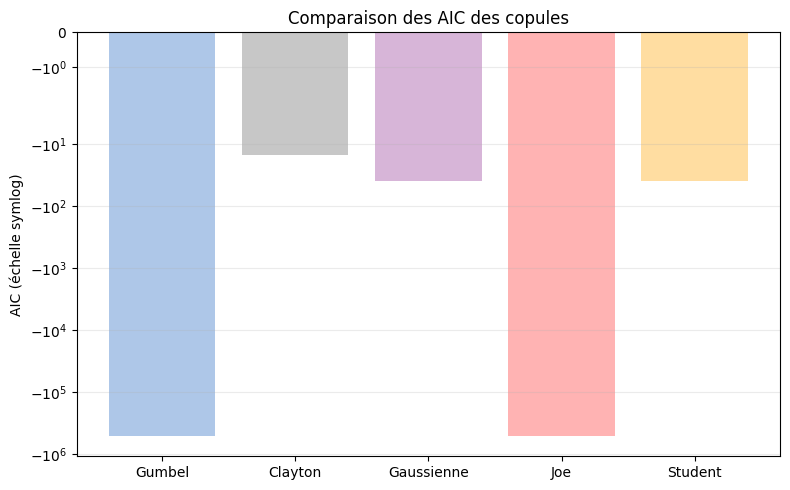

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Copule": ["Gumbel", "Clayton", "Gaussienne", "Joe", "Student"],
    "AIC": [
        -509404.301,
        -15.007,
        -39.097,
        -508273.219,
        -39.13886495680193
    ]
}

df = pd.DataFrame(data)

# Palette pastel
colors = {
    "Gumbel": "#aec7e8",      # bleu pastel
    "Joe": "#ffb3b3",         # rouge pastel
    "Clayton": "#c7c7c7",     # gris pastel
    "Gaussienne": "#d7b5d8",  # violet pastel
    "Student": "#ffdda1"      # orange pastel
}

bar_colors = [colors[c] for c in df["Copule"]]

plt.figure(figsize=(8,5))
plt.bar(df["Copule"], df["AIC"], color=bar_colors)
plt.yscale("symlog")
plt.ylabel("AIC (échelle symlog)")
plt.title("Comparaison des AIC des copules")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


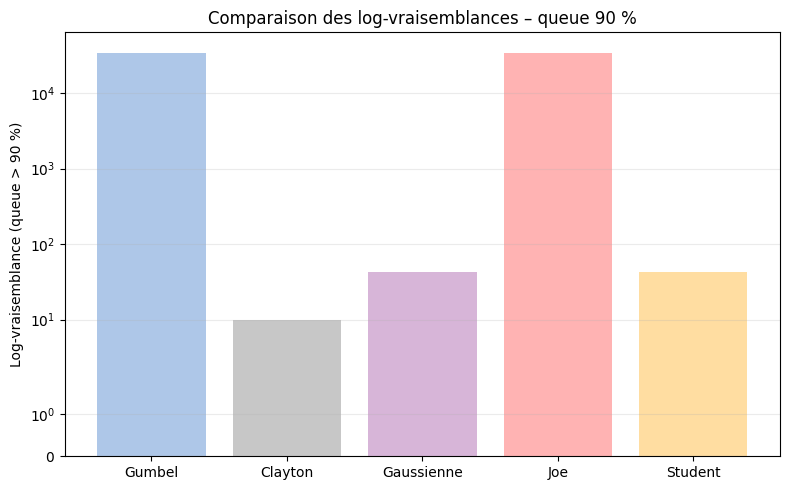

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Copule": ["Gumbel", "Clayton", "Gaussienne", "Joe", "Student"],
    "LL_tail": [
        34527.049,
        9.768,
        42.433,
        34369.851,
        43.19907699132402
    ]
}

df = pd.DataFrame(data)

# Même palette pastel que pour l’AIC
colors = {
    "Gumbel": "#aec7e8",      # bleu pastel
    "Joe": "#ffb3b3",         # rouge pastel
    "Clayton": "#c7c7c7",     # gris pastel
    "Gaussienne": "#d7b5d8",  # violet pastel
    "Student": "#ffdda1"      # orange pastel
}

bar_colors = [colors[c] for c in df["Copule"]]

plt.figure(figsize=(8,5))
plt.bar(df["Copule"], df["LL_tail"], color=bar_colors)
plt.yscale("symlog")  # même logique que pour l’AIC
plt.ylabel("Log-vraisemblance (queue > 90 %)")
plt.title("Comparaison des log-vraisemblances – queue 90 %")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


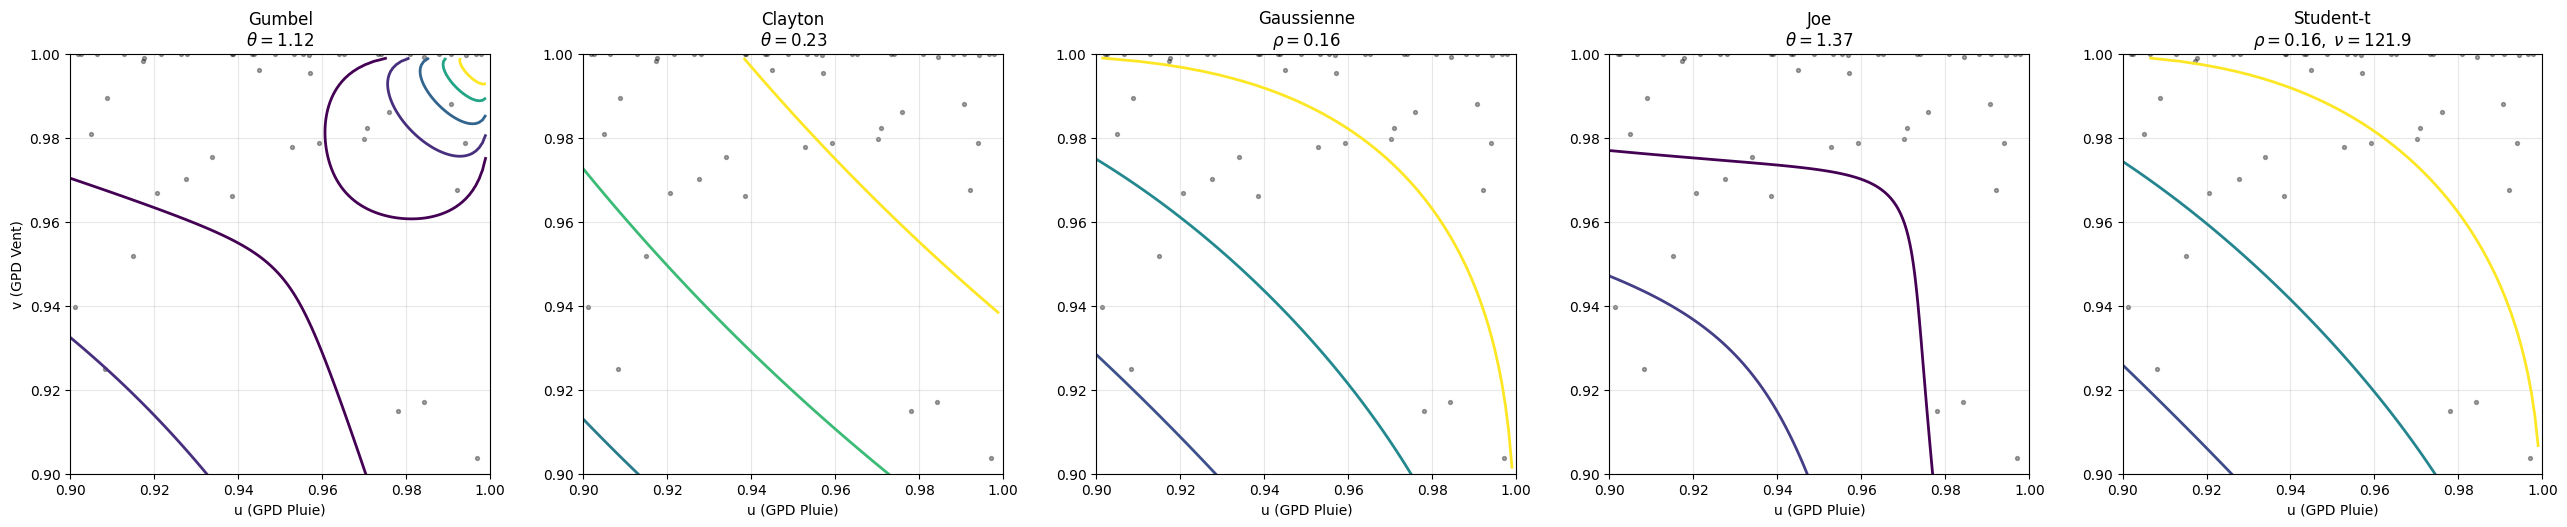

In [106]:
# u,v = extrêmes conjoints GPD
u = np.asarray(U_conjoint)
v = np.asarray(V_conjoint)
mask = np.isfinite(u) & np.isfinite(v)
u = u[mask]; v = v[mask]

# ---- ZOOM QUEUE ----
u_min, v_min = 0.9, 0.9
grid = np.linspace(0.8, 0.999, 250)
U_grid, V_grid = np.meshgrid(grid, grid)

fig, axes = plt.subplots(1, 5, figsize=(26, 5))

def contour_levels(Z):
    lv = np.quantile(Z, [0.2, 0.4, 0.6, 0.8, 0.95])
    return np.unique(lv)

# ---------- GUMBEL ----------
axes[0].scatter(u, v, s=8, alpha=0.35, color="black")
Z_g = pdf_gumbel(U_grid, V_grid, theta_gumbel)
axes[0].contour(U_grid, V_grid, Z_g, levels=contour_levels(Z_g), linewidths=2)
axes[0].set_title(f"Gumbel\n$\\theta={theta_gumbel:.2f}$")
axes[0].set_xlabel("u (GPD Pluie)")
axes[0].set_ylabel("v (GPD Vent)")

# ---------- CLAYTON ----------
axes[1].scatter(u, v, s=8, alpha=0.35, color="black")
Z_c = pdf_clayton(U_grid, V_grid, theta_clayton)
axes[1].contour(U_grid, V_grid, Z_c, levels=contour_levels(Z_c), linewidths=2)
axes[1].set_title(f"Clayton\n$\\theta={theta_clayton:.2f}$")
axes[1].set_xlabel("u (GPD Pluie)")

# ---------- GAUSS ----------
axes[2].scatter(u, v, s=8, alpha=0.35, color="black")
Z_n = pdf_gauss(U_grid, V_grid, rho_gauss)
axes[2].contour(U_grid, V_grid, Z_n, levels=contour_levels(Z_n), linewidths=2)
axes[2].set_title(f"Gaussienne\n$\\rho={rho_gauss:.2f}$")
axes[2].set_xlabel("u (GPD Pluie)")

# ---------- JOE ----------
axes[3].scatter(u, v, s=8, alpha=0.35, color="black")
Z_j = pdf_joe(U_grid, V_grid, theta_joe)
axes[3].contour(U_grid, V_grid, Z_j, levels=contour_levels(Z_j), linewidths=2)
axes[3].set_title(f"Joe\n$\\theta={theta_joe:.2f}$")
axes[3].set_xlabel("u (GPD Pluie)")

# ---------- STUDENT ----------
axes[4].scatter(u, v, s=8, alpha=0.35, color="black")
Z_t = pdf_student_copula(U_grid, V_grid, nu_student, rho_student)
axes[4].contour(U_grid, V_grid, Z_t, levels=contour_levels(Z_t), linewidths=2)
axes[4].set_title(f"Student-t\n$\\rho={rho_student:.2f},\\;\\nu={nu_student:.1f}$")
axes[4].set_xlabel("u (GPD Pluie)")

# ---- FORMAT COMMUN ----
for ax in axes:
    ax.set_xlim(u_min, 1.0)
    ax.set_ylim(v_min, 1.0)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# V/ De la copule à des niveaux de retour

## **A) Gumbel**

In [108]:
time_joint = df_joint.index  # index time

dt = pd.DatetimeIndex(time_joint)
years = dt.year.to_numpy()
months = dt.month.to_numpy()

is_djf = np.isin(months, [12, 1, 2])

# DJF "year" : Décembre appartient à l'hiver suivant
djf_year = years.copy()
djf_year[months == 12] = djf_year[months == 12] + 1

n_days_djf_total = int(is_djf.sum())
n_seasons = len(np.unique(djf_year[is_djf]))

N_DJF = n_days_djf_total / n_seasons

print("Total jours DJF =", n_days_djf_total)
print("Nombre de saisons DJF =", n_seasons)
print("Jours DJF moyens par saison =", N_DJF)

Total jours DJF = 7550
Nombre de saisons DJF = 84
Jours DJF moyens par saison = 89.88095238095238


In [109]:
def C_gumbel(u, v, theta, eps=1e-12):
    u = np.clip(u, eps, 1 - eps)
    v = np.clip(v, eps, 1 - eps)

    x = -np.log(u)
    y = -np.log(v)

    A = (x**theta + y**theta)**(1/theta)
    return np.exp(-A)

### 1.Seuil de 100 ans (calculé sur 1940-1980)

# A refaire

In [ ]:
# seuils physiques qui est dépassé en 10 ans pour la période 1940-1980
x100 = 1096.714660730046
y100 = 1.017354328599085

#CDF GPD
u_star = genpareto.cdf(x100, c=c4, loc=loc4, scale=scale4)  # F_X(x100)
v_star = genpareto.cdf(y100, c=c5, loc=loc5, scale=scale5)  # F_Y(y100)

print("u_star =", u_star)
print("v_star =", v_star)


# Probabilité AND par jour (copule gaussienne)
C_uv = C_gauss(u_star, v_star, rho_gauss)
p_and_gauss_day = 1 - u_star - v_star + C_uv

# Indépendance
p_and_ind_day = (1-u_star)*(1-v_star)

# Périodes de retour (en années)
T_and_gauss_years = 1/(90*p_and_gauss_day)
T_and_ind_years   = 1/(90*p_and_ind_day)

# LMF
LMF_gauss = p_and_gauss_day / p_and_ind_day

print("p_AND (Gauss) par jour: p_and_gauss_day=", p_and_gauss_day)
print("p_AND (indep) par jour: p_and_ind_day =", p_and_ind_day)
print("Return period AND (Gauss) en années =", T_and_gauss_years)
print("Return period AND (indep) en années =", T_and_ind_years)
print("LMF (Gauss) =", LMF_gauss)


**Commentaire:** À refaire